In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from classes.QLearningAgentClass import QLearningAgent
from envs.createEnvs import createNNEnv
from utilities.plots import create_grids, plot_trajectory
from utilities.jsonRW import writeJSON, readJSON

In [2]:
shape="14x14"

env = createNNEnv(shape)

Loading models...
Models loaded


In [3]:
# hyperparameters
if shape == "5x5":
    n_episodes = 5000
elif shape == "14x14":
    n_episodes = 15000


train = True            # train or test
show_stats = False       # show stats
export_to_JSON = True   # write JSON file
render = True           # render the results after training

NUM_AGENTS = 50

learning_rate = 0.02
start_epsilon = 1.0
epsilon_decay = start_epsilon/(n_episodes/2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factor = 0.95

agents_arr = []
starting_positions = []

In [4]:
if train:
    print("Starting training of", NUM_AGENTS, "Q-learning agents")

    for i in range(NUM_AGENTS):
        print("Agent", i+1, "/", NUM_AGENTS)

        #env.unwrapped.randomize_start_pos()
        agent = QLearningAgent(env, n_episodes, learning_rate, start_epsilon, epsilon_decay, final_epsilon, discount_factor)
        agent.env.unwrapped.randomize_start_pos()
        agent.train()
        
        agents_arr.append(agent)
        starting_positions.append(agent.env.unwrapped.start_pos)

Starting training of 50 Q-learning agents
Agent 1 / 50


100%|██████████| 15000/15000 [05:12<00:00, 47.96it/s] 


Agent 2 / 50


100%|██████████| 15000/15000 [06:47<00:00, 36.80it/s] 


Agent 3 / 50


100%|██████████| 15000/15000 [04:29<00:00, 55.66it/s] 


Agent 4 / 50


100%|██████████| 15000/15000 [04:40<00:00, 53.57it/s] 


Agent 5 / 50


100%|██████████| 15000/15000 [04:45<00:00, 52.48it/s] 


Agent 6 / 50


  2%|▏         | 315/15000 [01:30<22:28, 10.89it/s]  

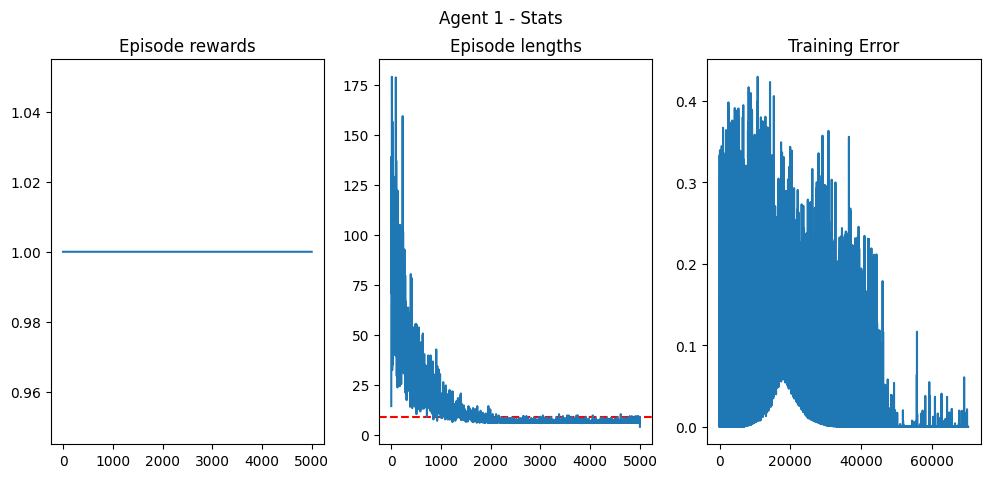

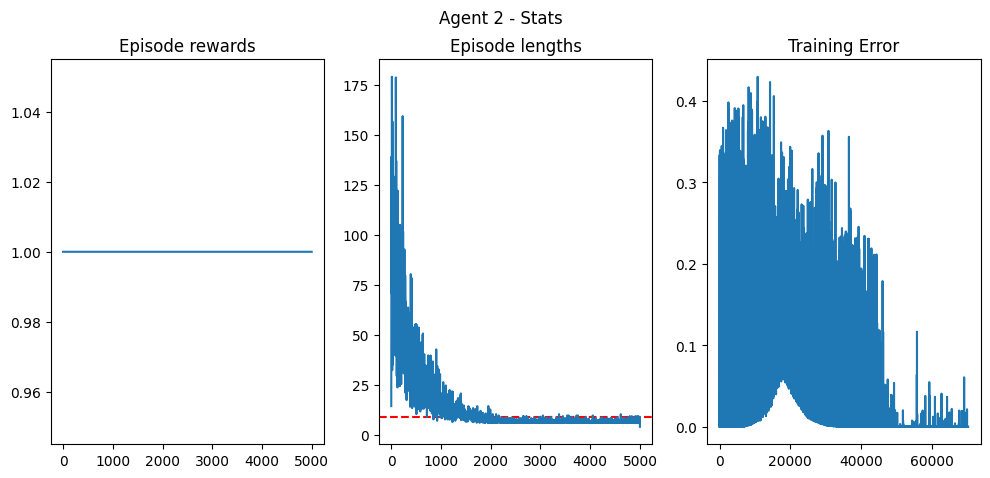

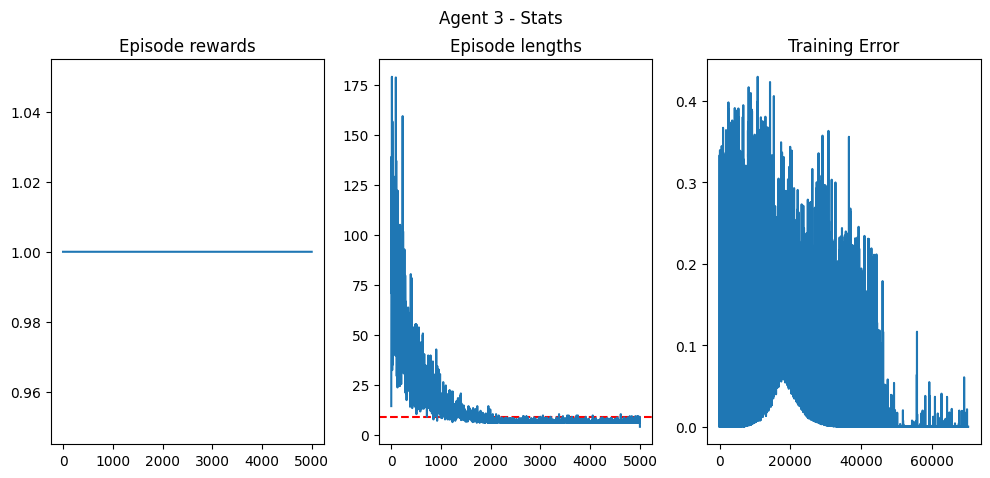

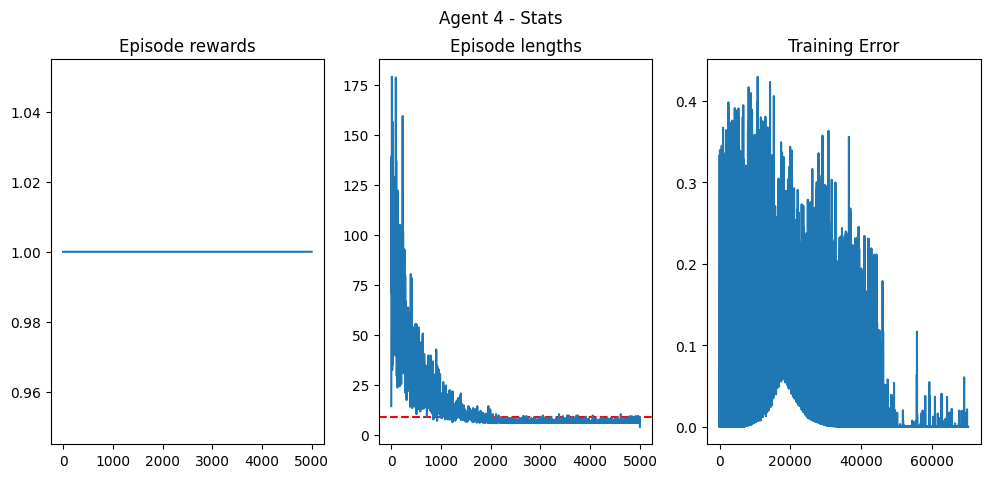

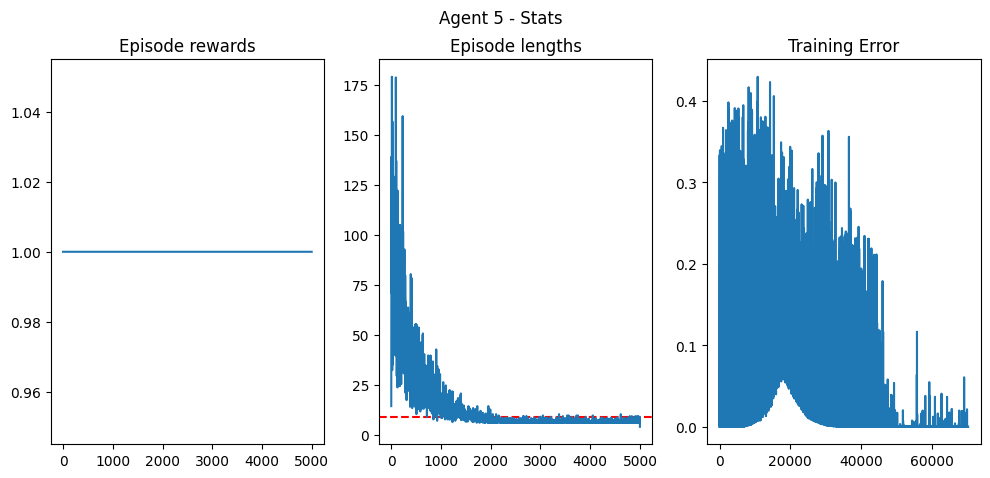

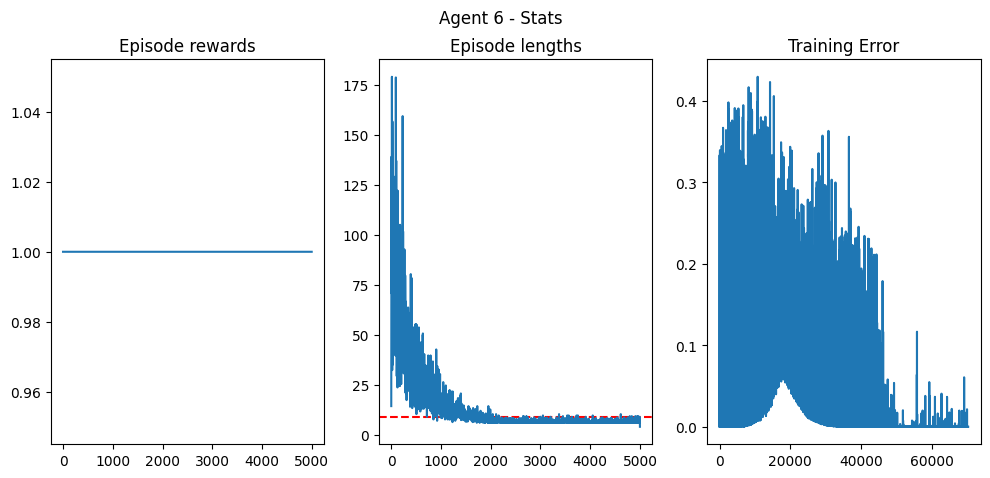

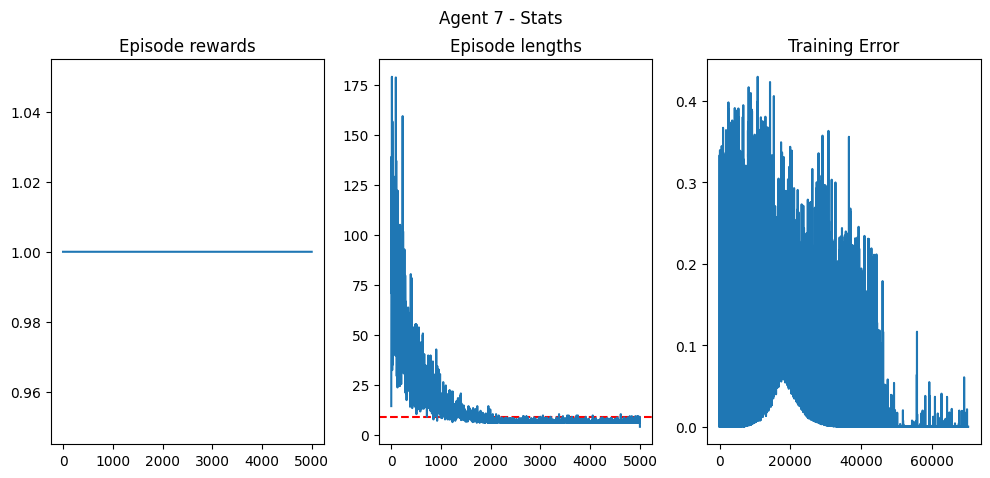

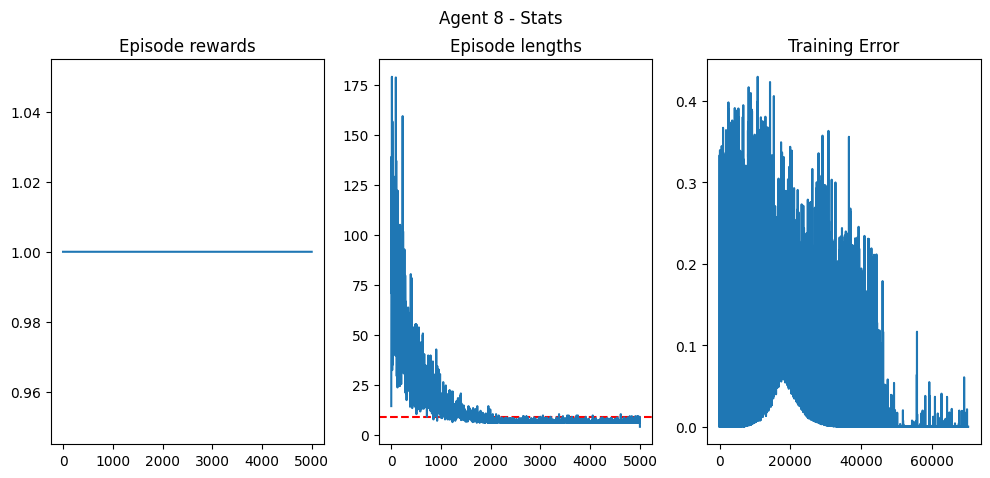

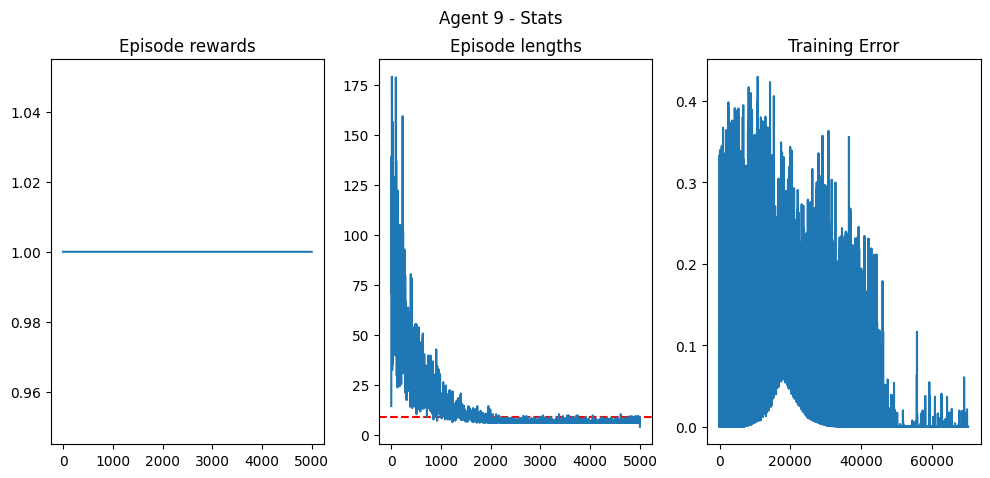

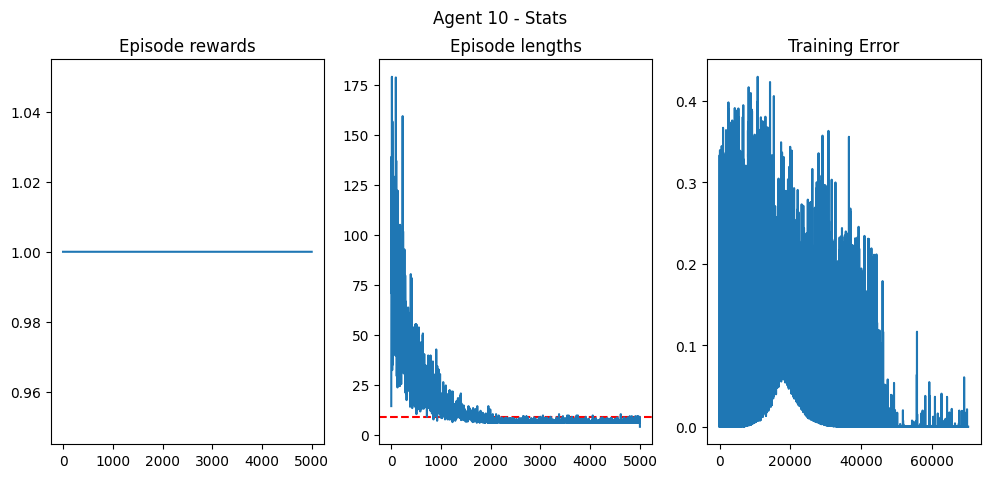

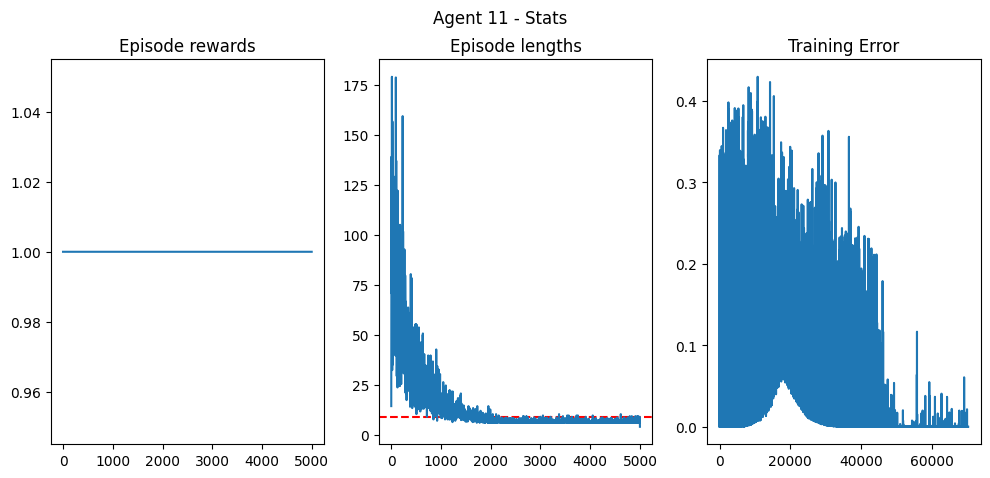

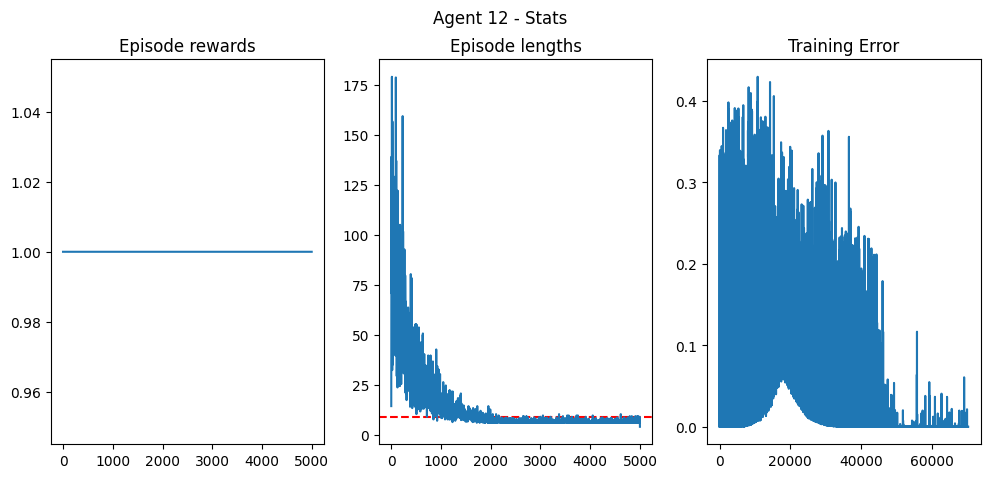

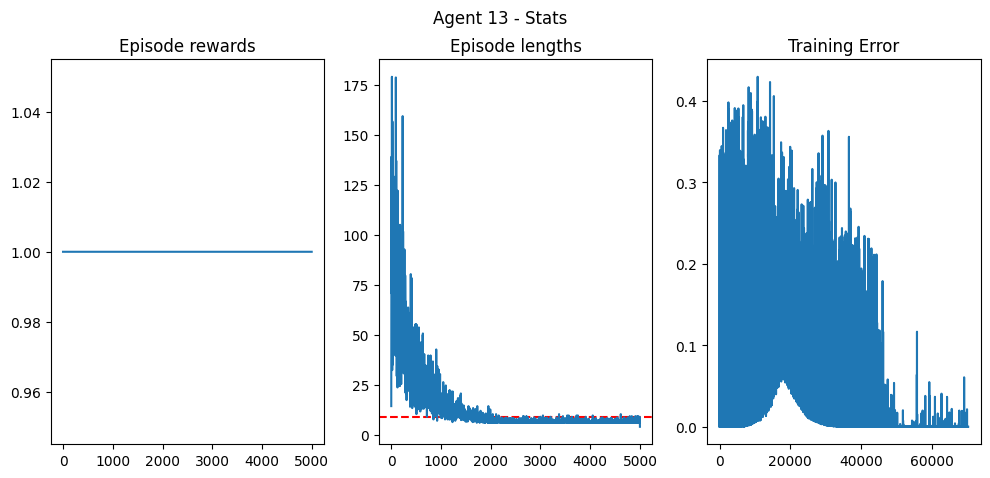

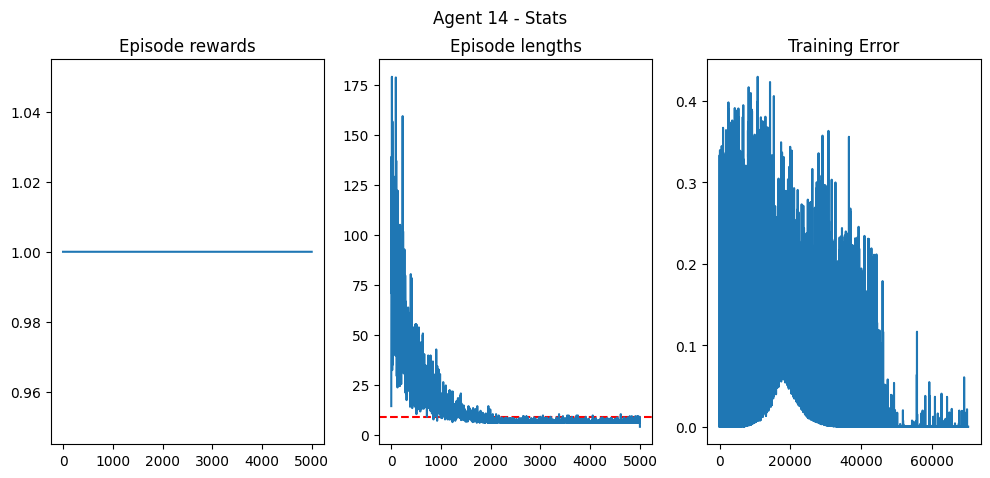

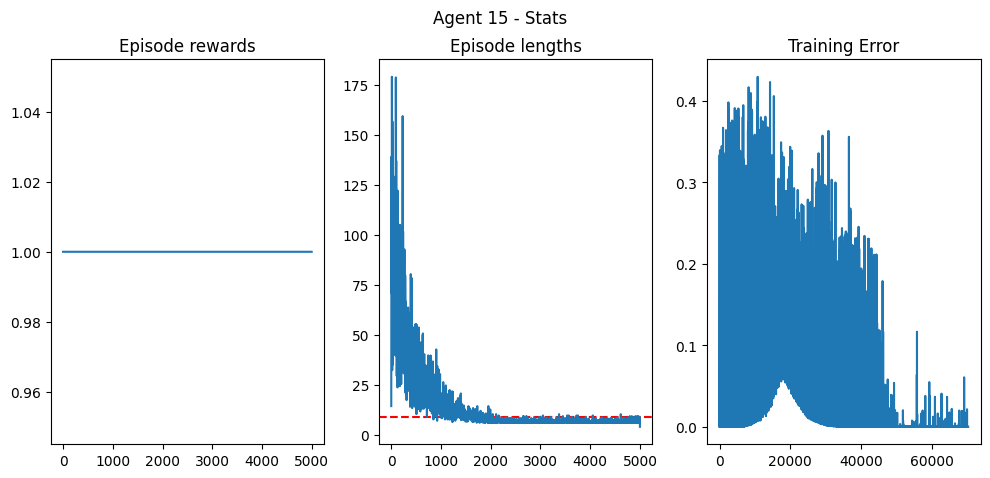

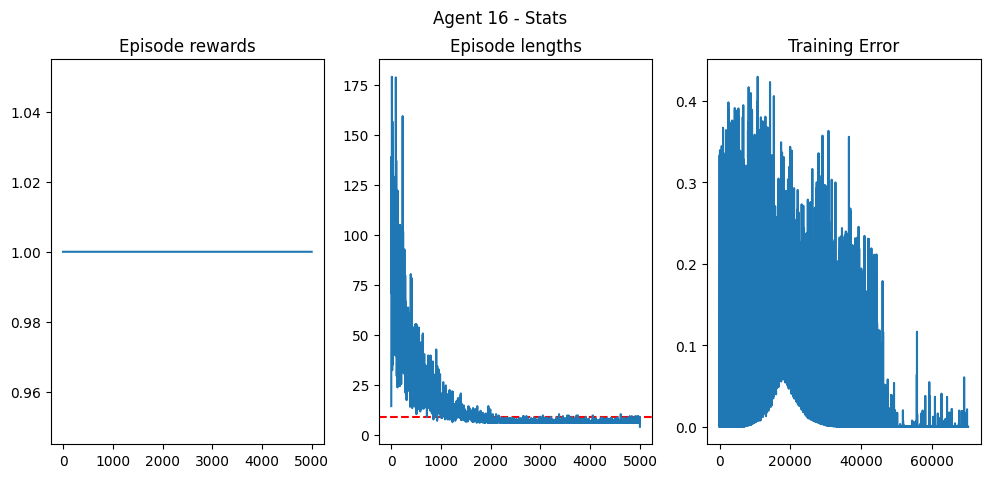

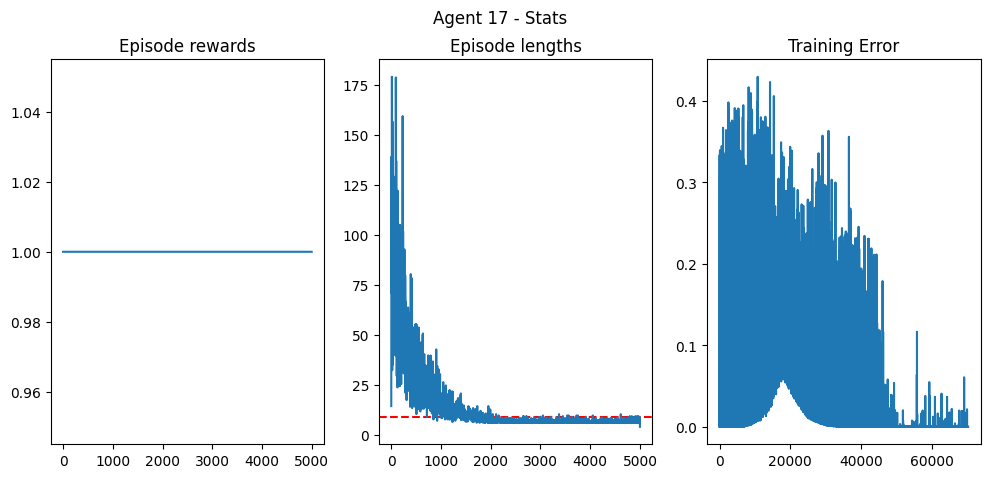

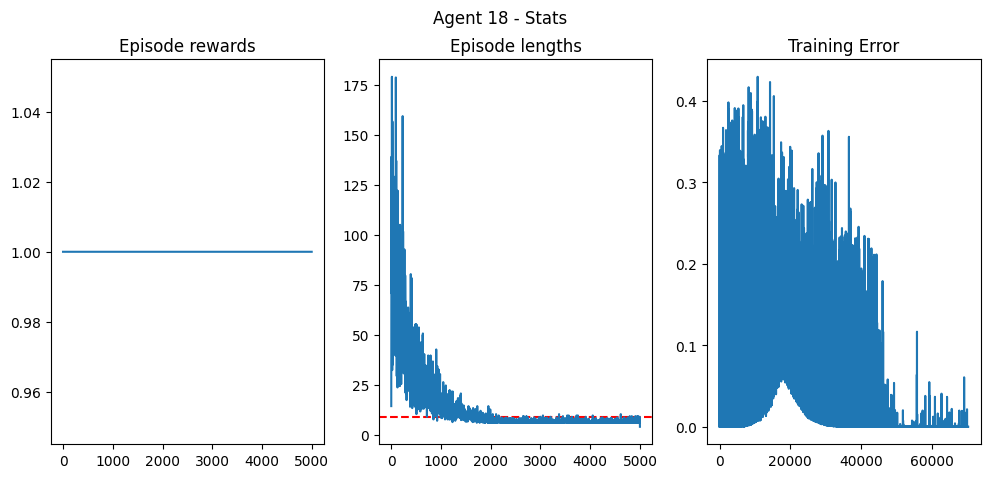

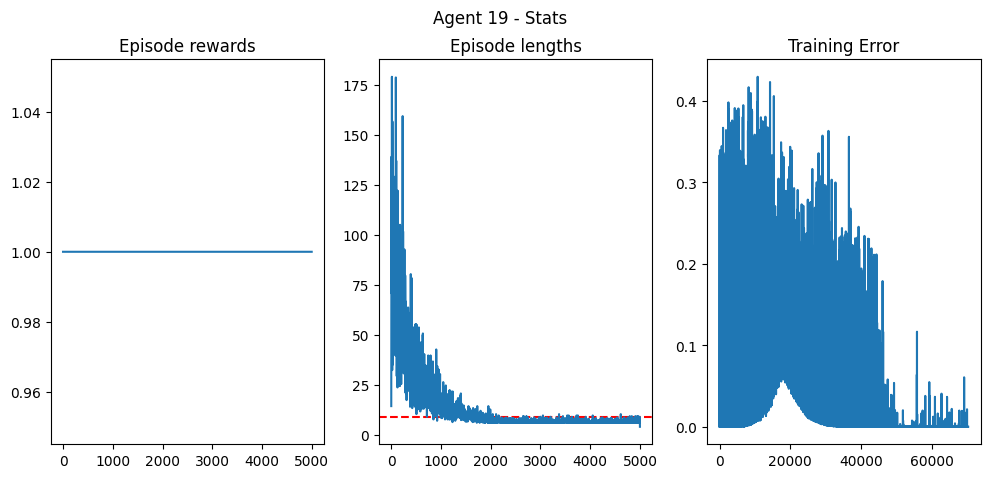

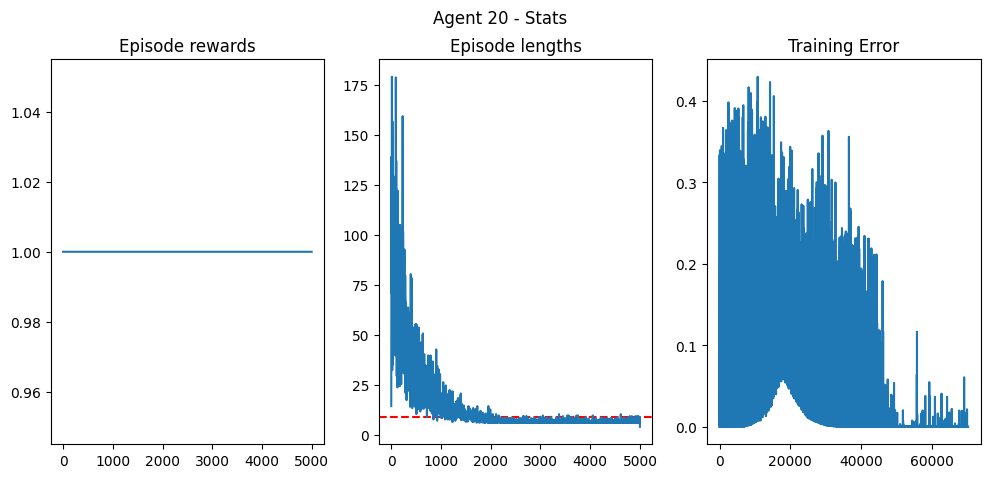

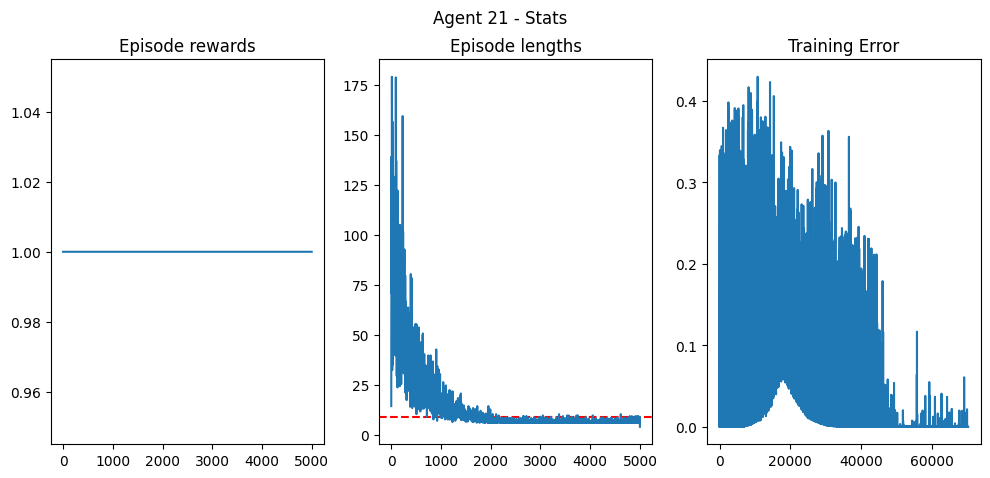

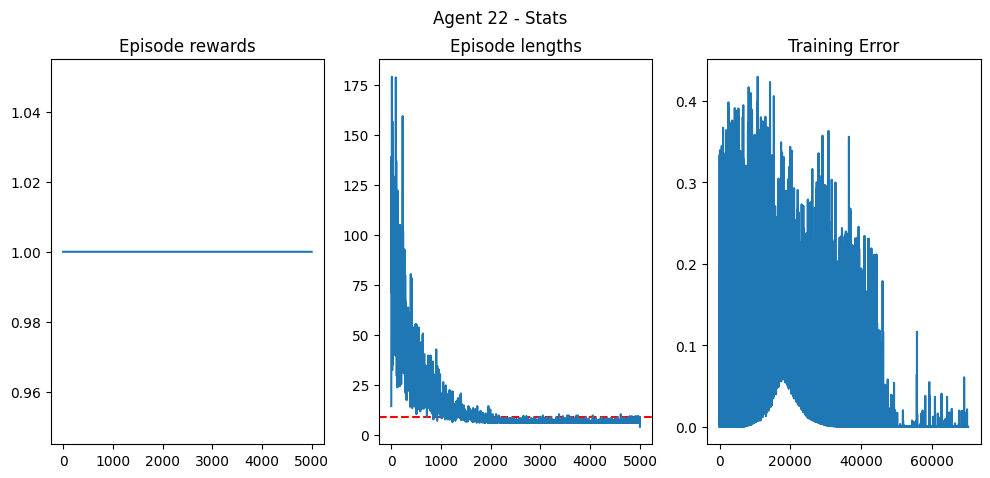

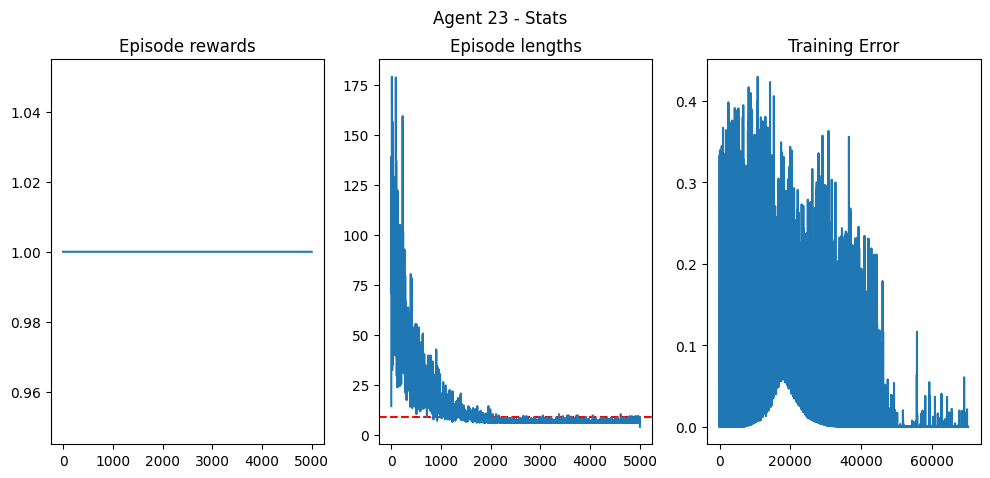

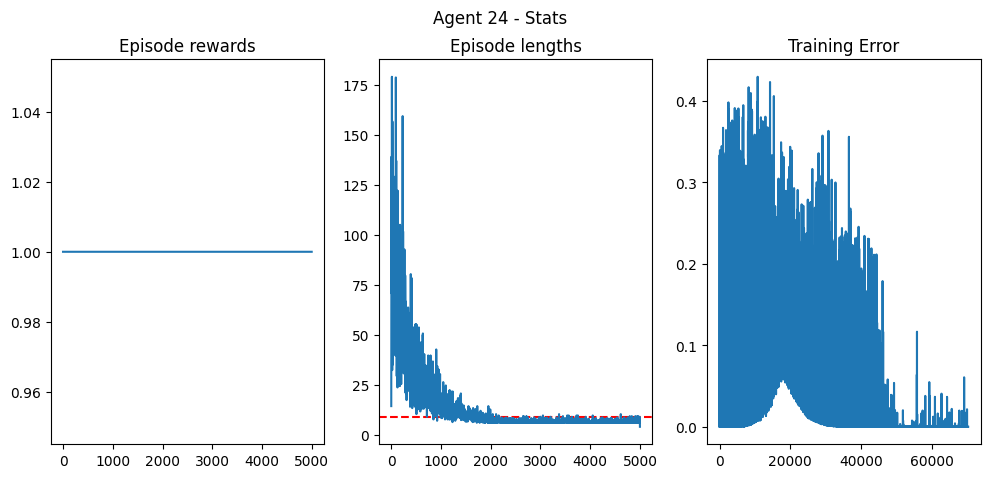

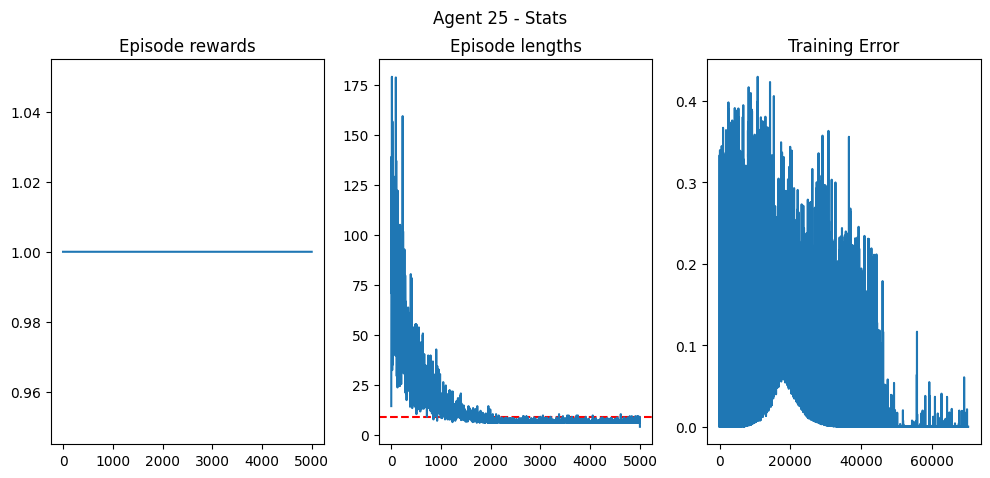

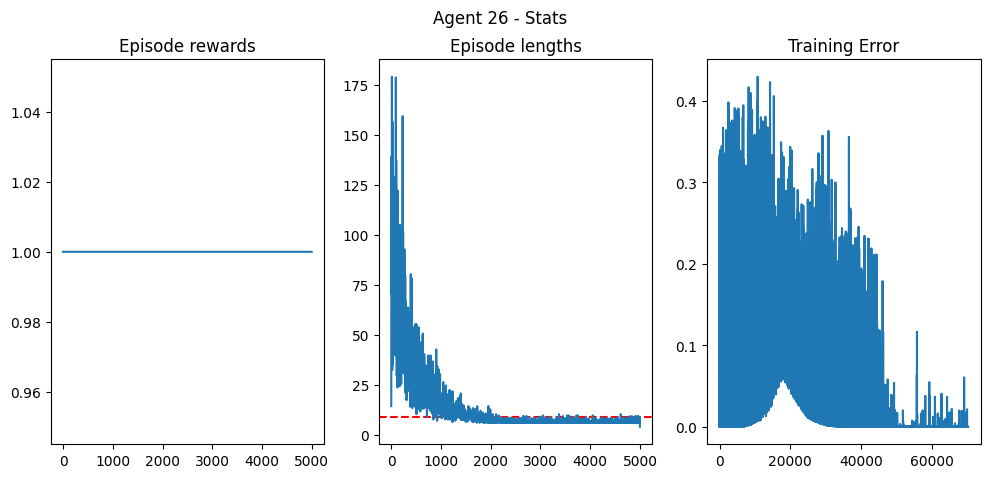

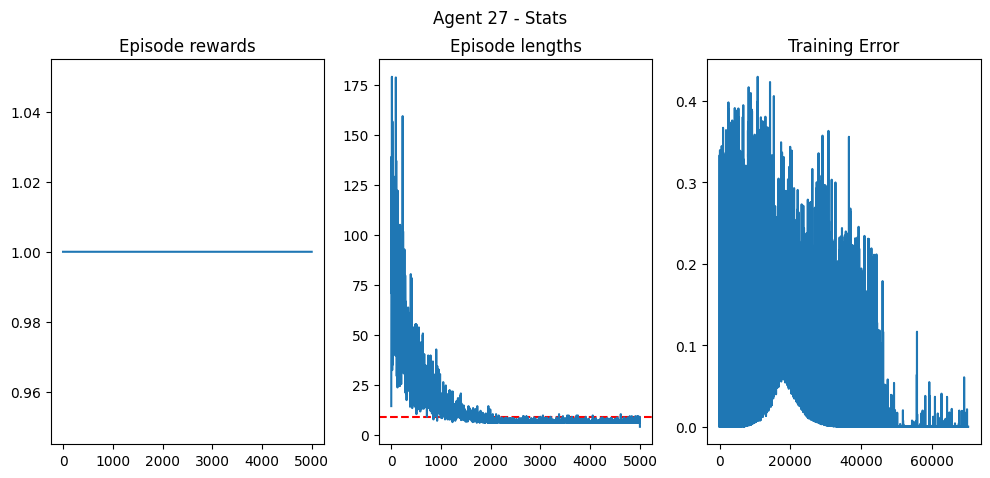

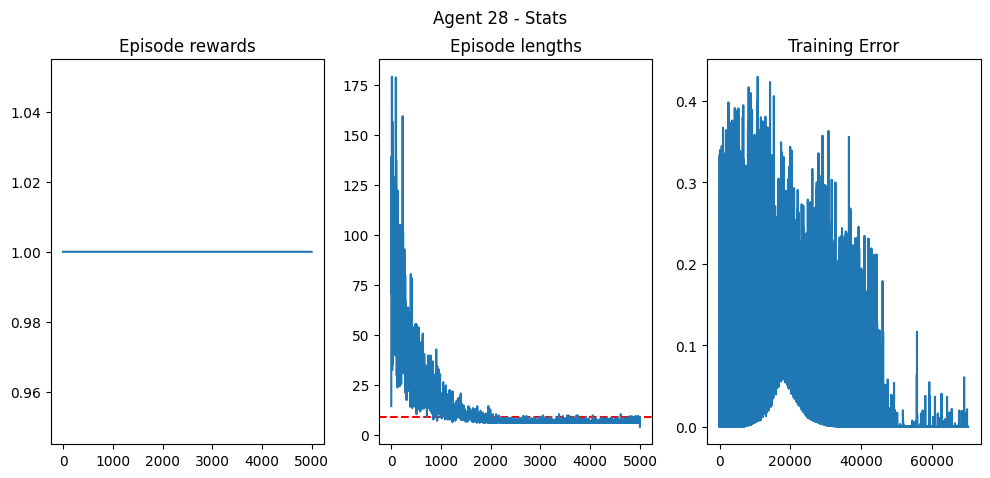

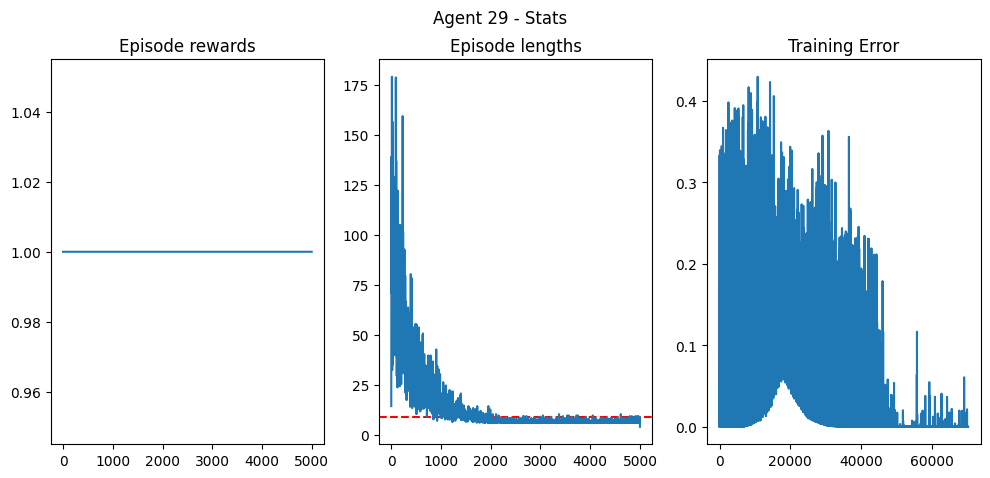

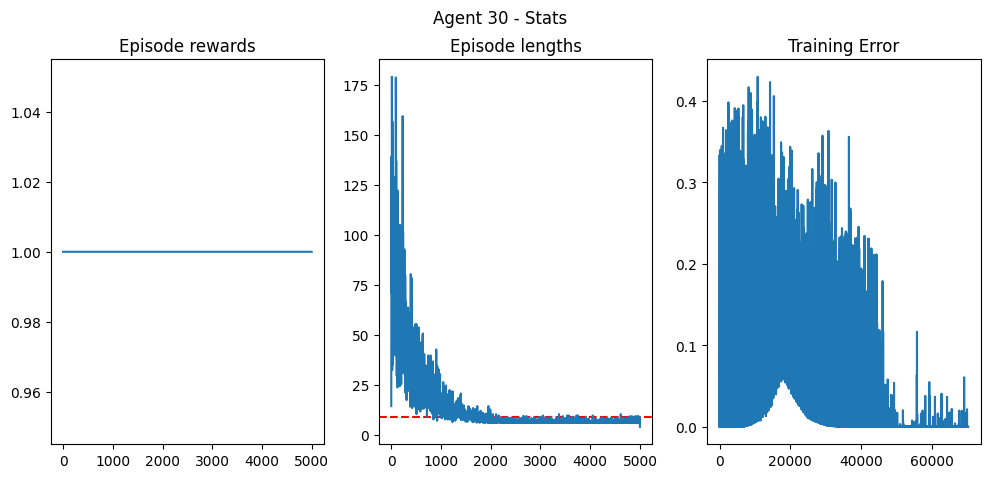

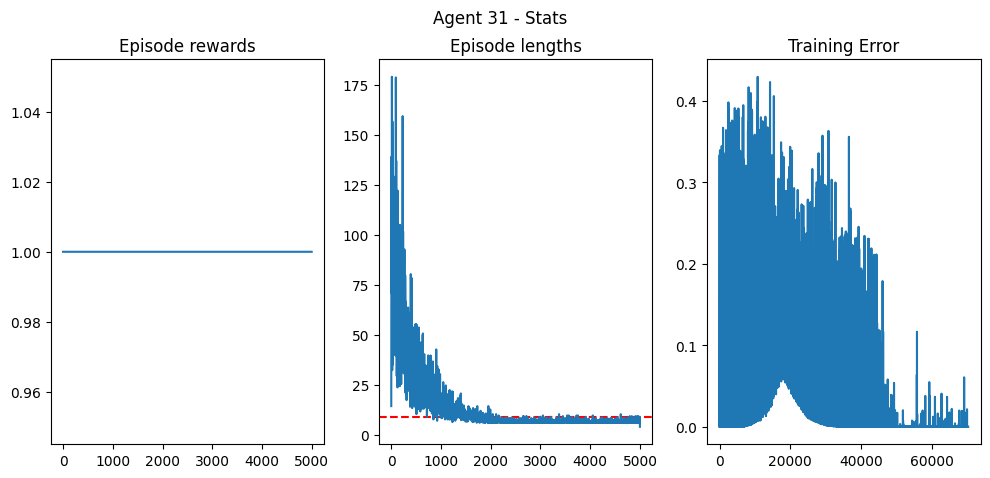

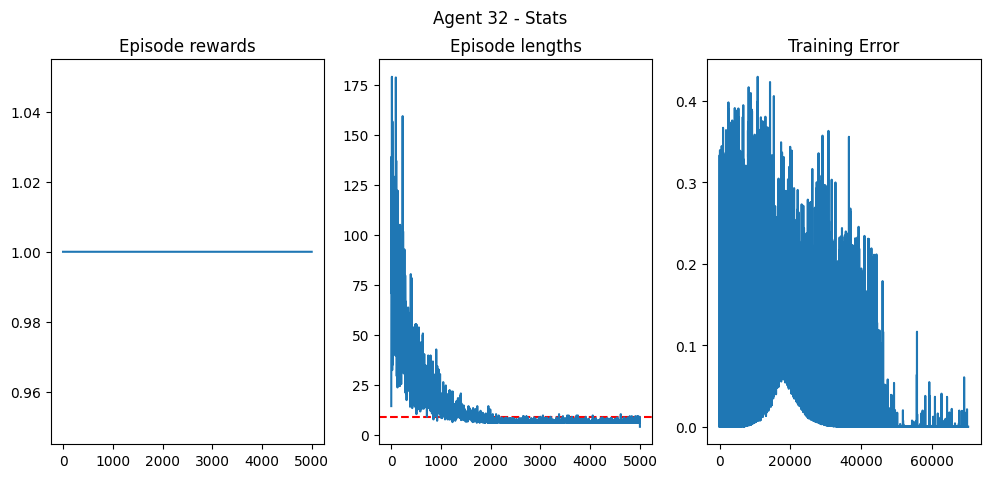

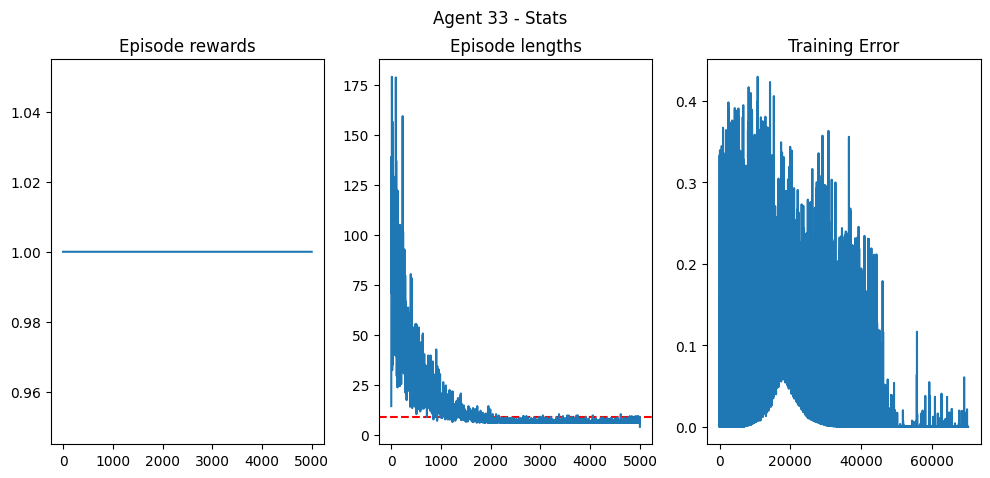

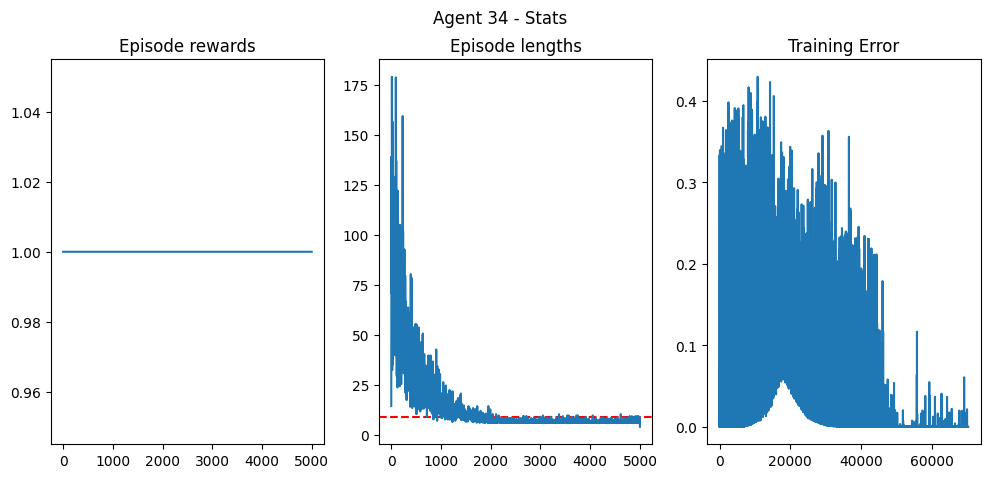

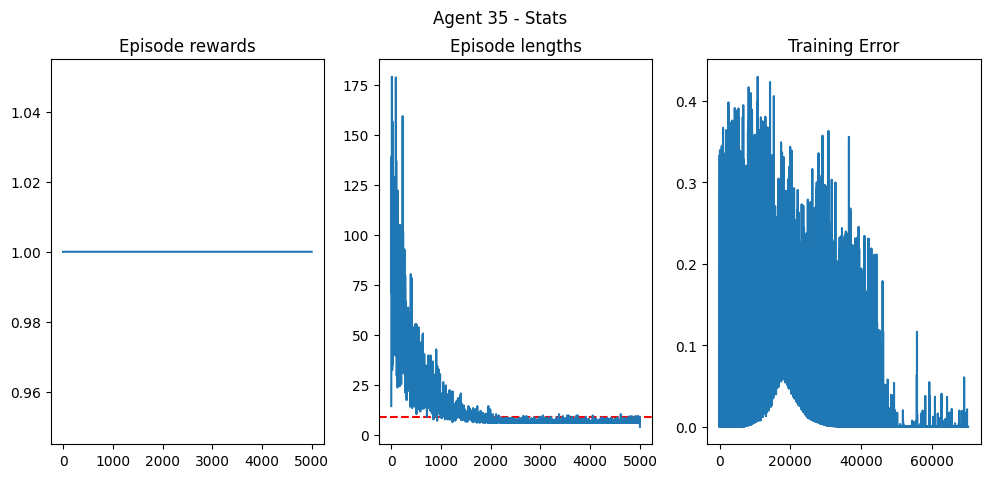

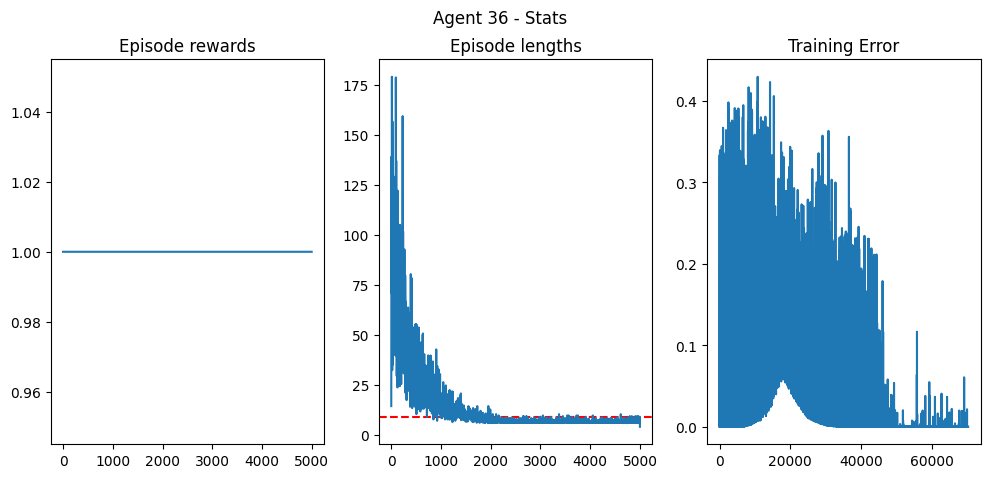

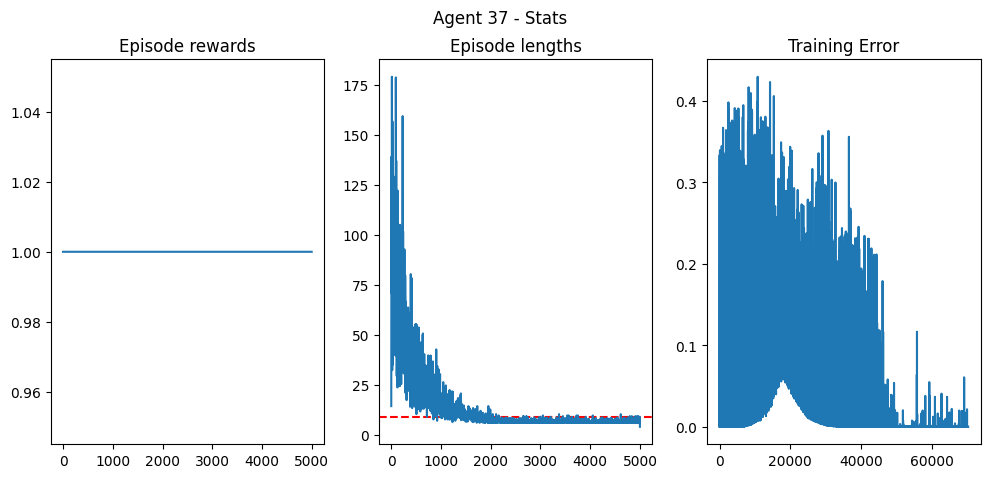

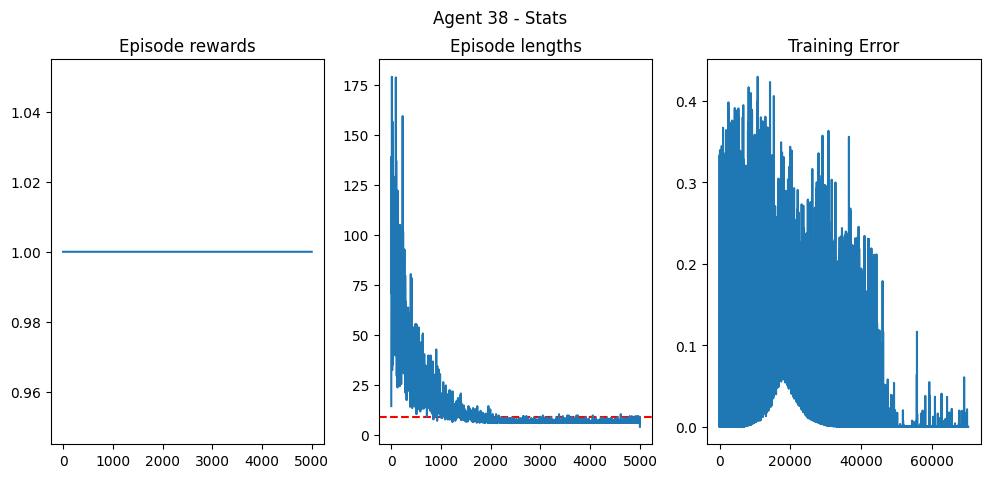

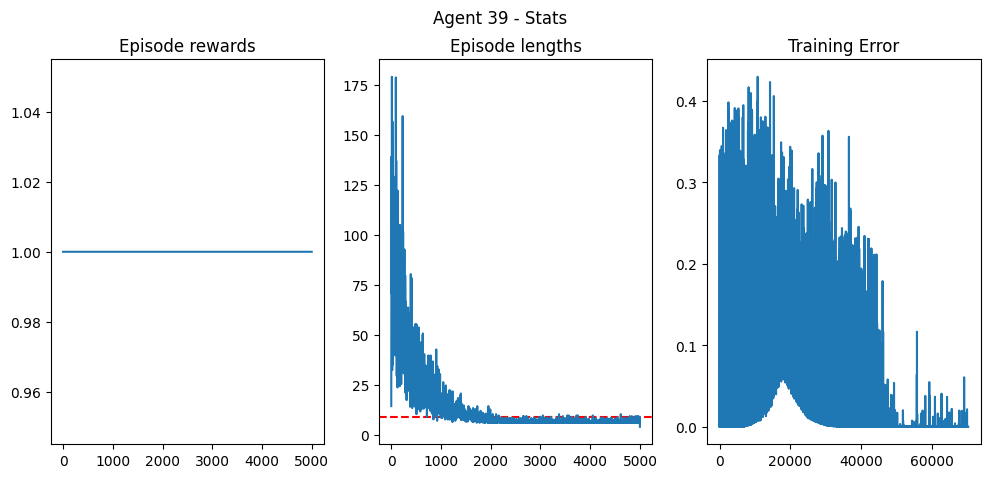

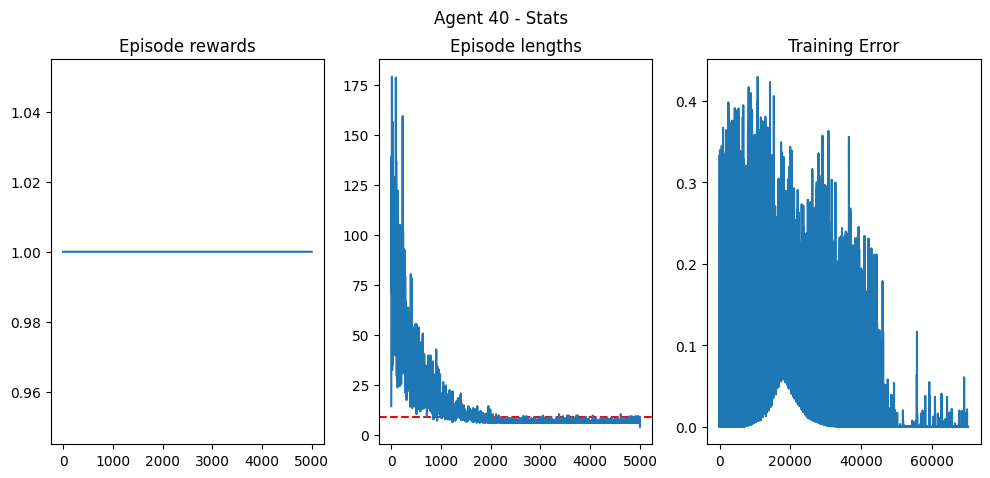

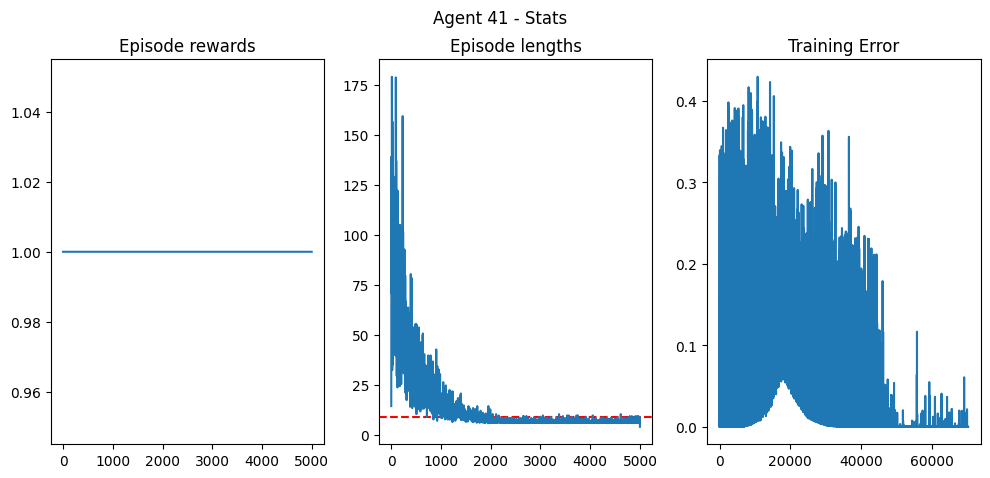

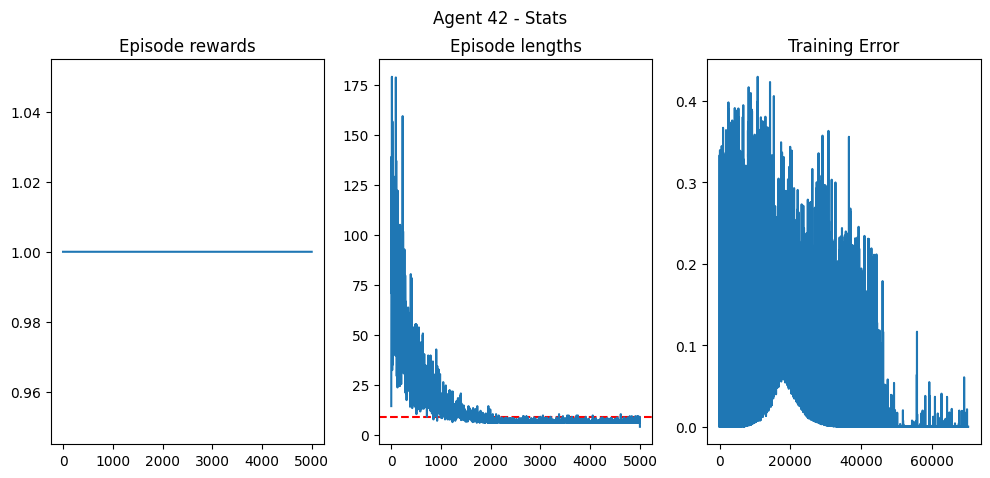

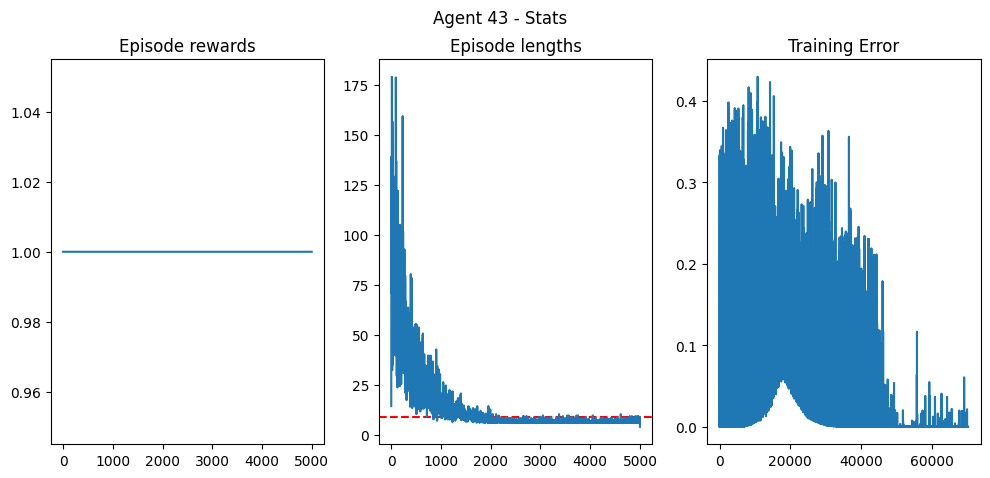

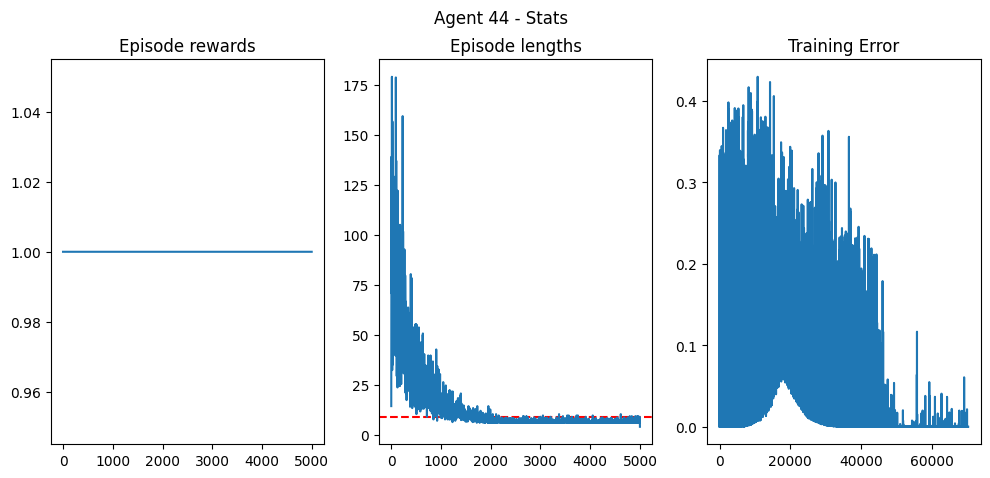

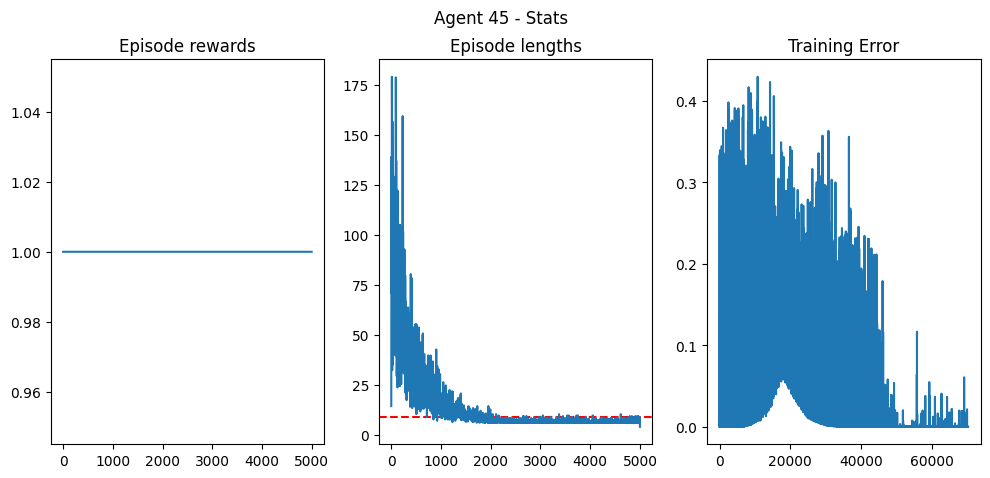

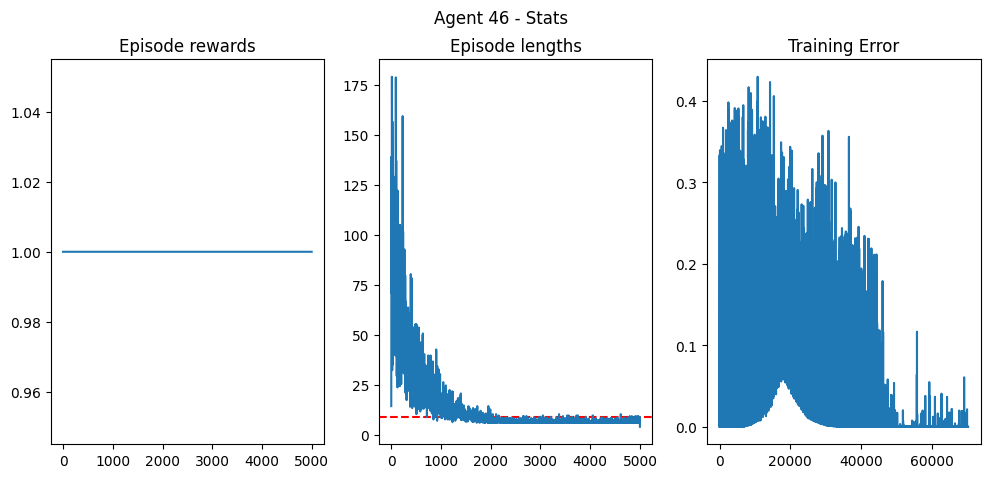

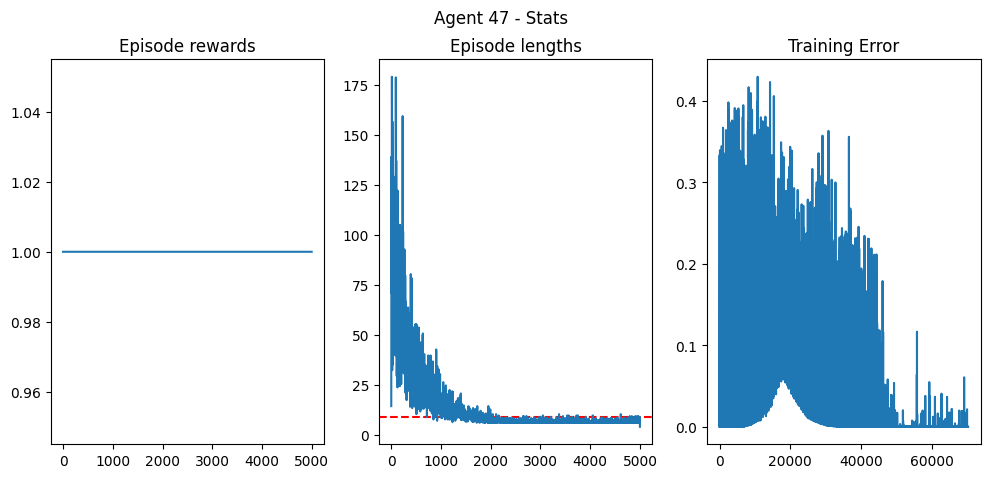

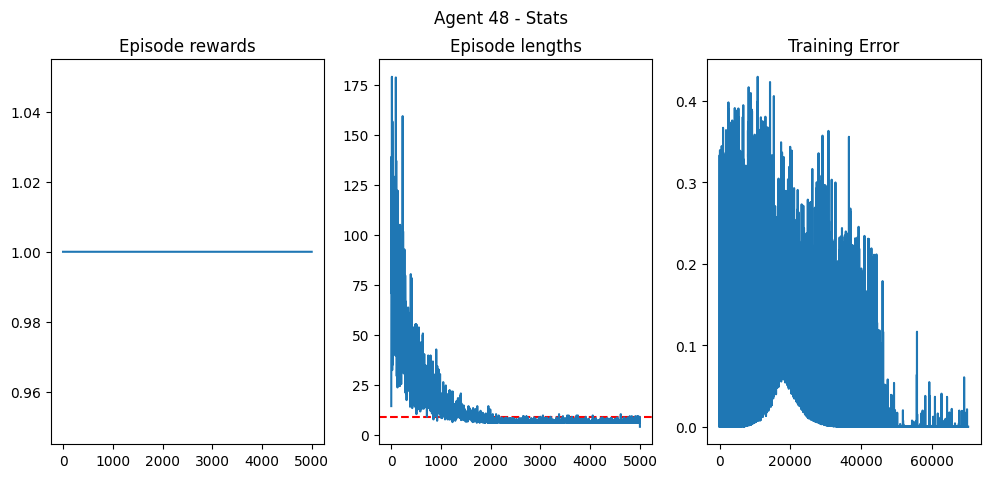

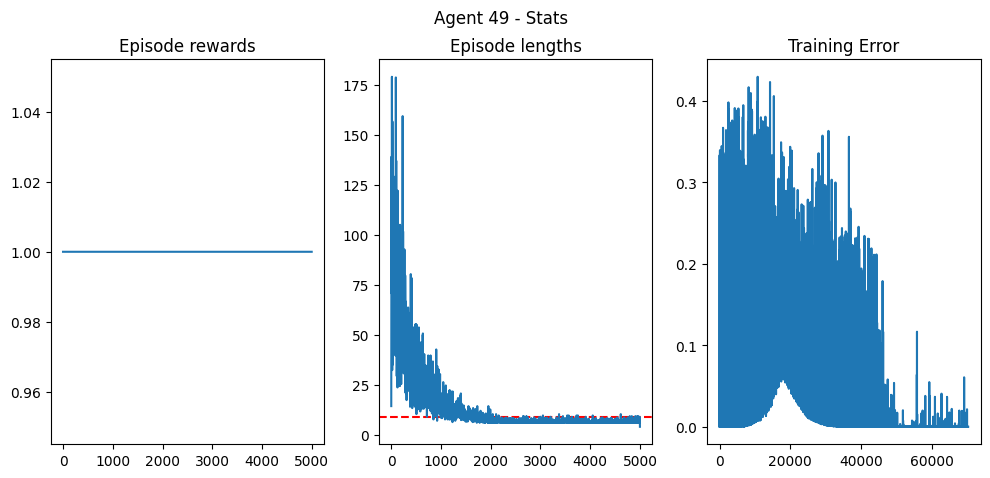

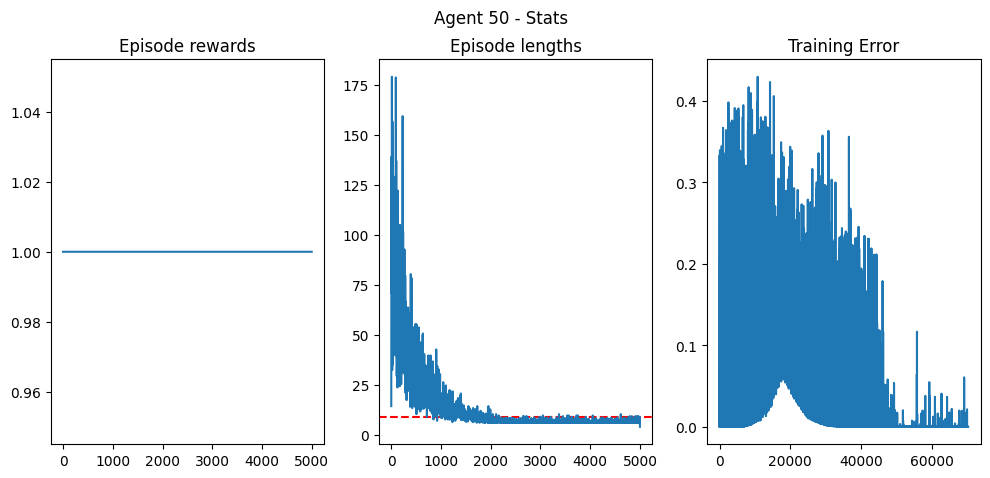

In [ ]:
if train and show_stats:
    for i in range(len(agents_arr)):
        fig = agent.plot_results()
        fig.suptitle(f'Agent {i+1} - Stats')
        plt.show()

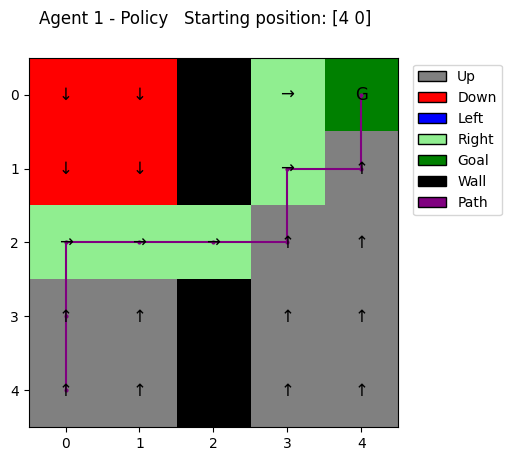

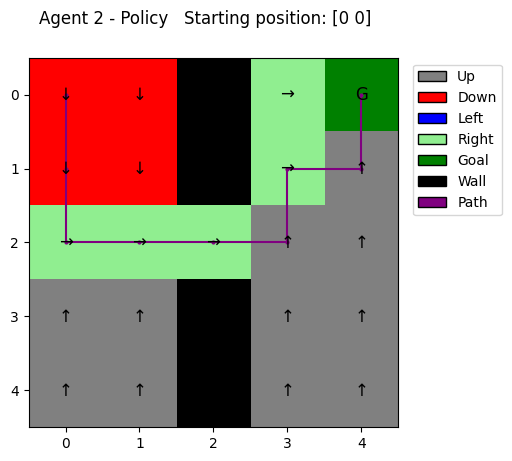

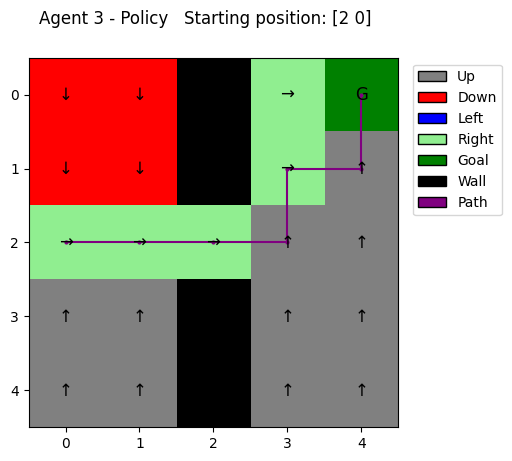

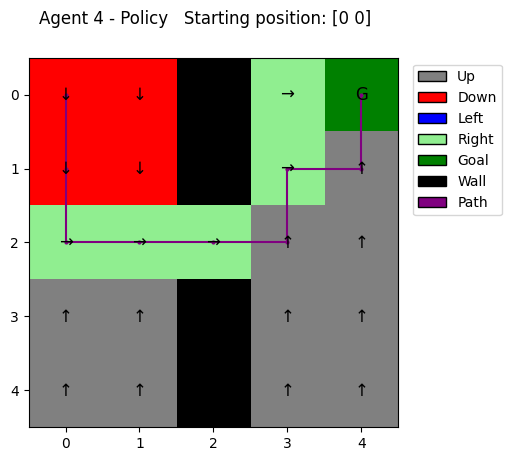

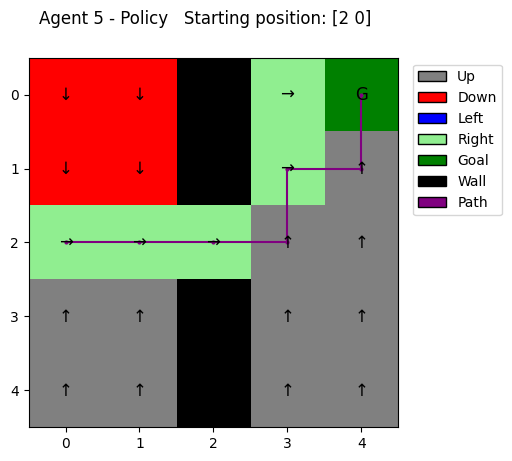

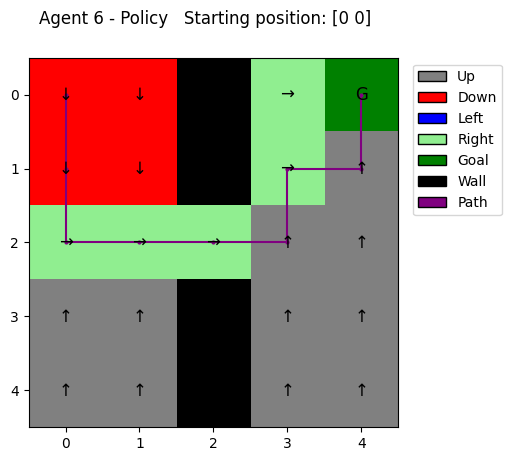

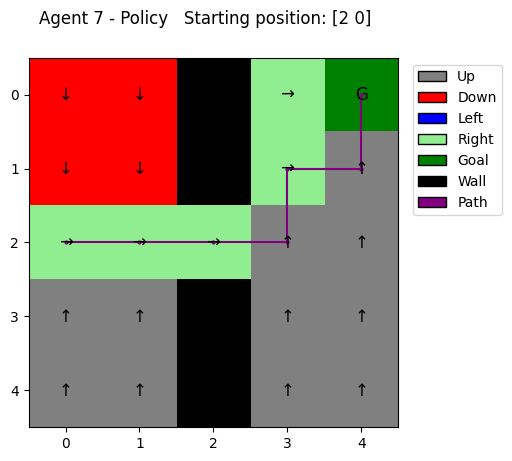

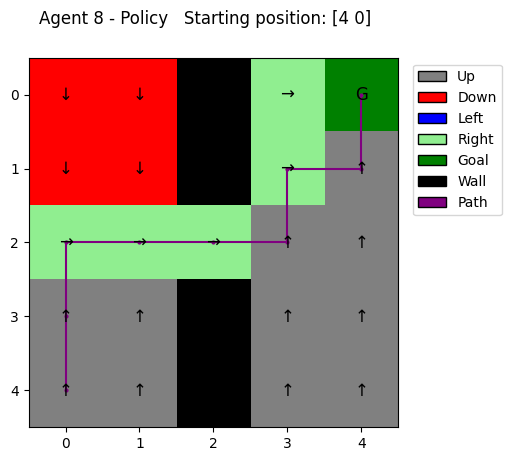

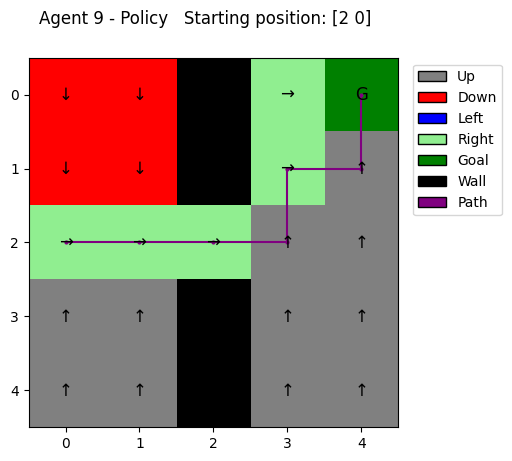

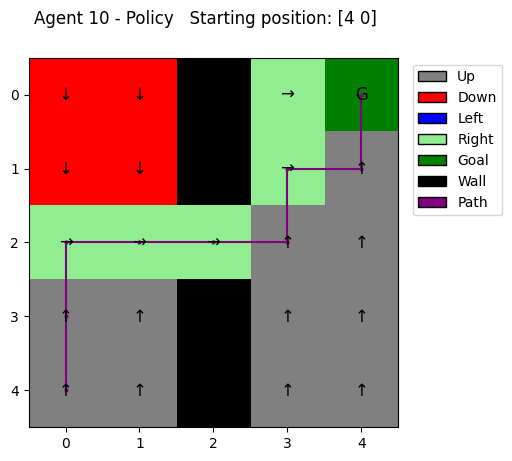

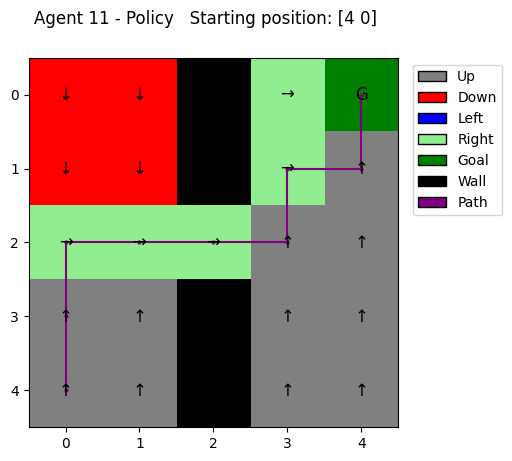

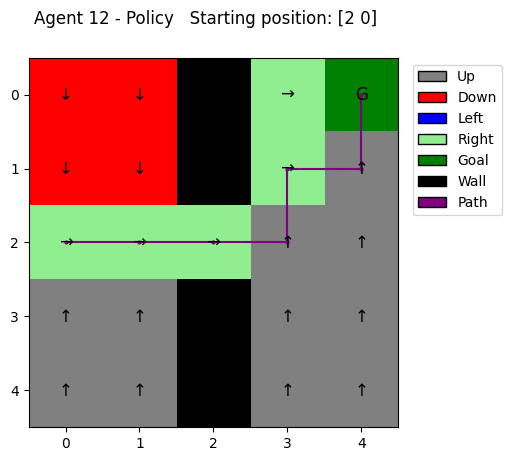

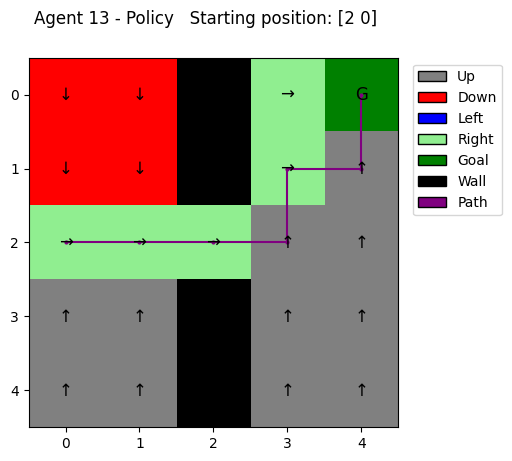

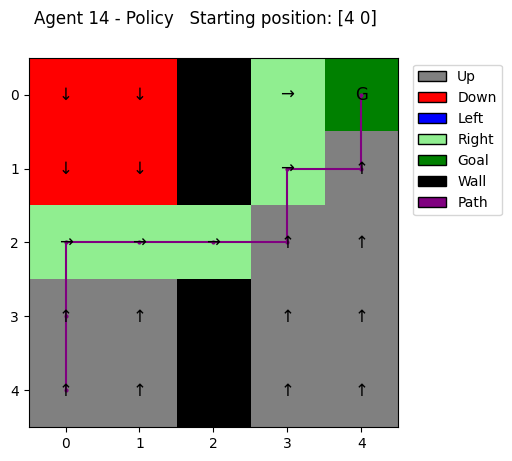

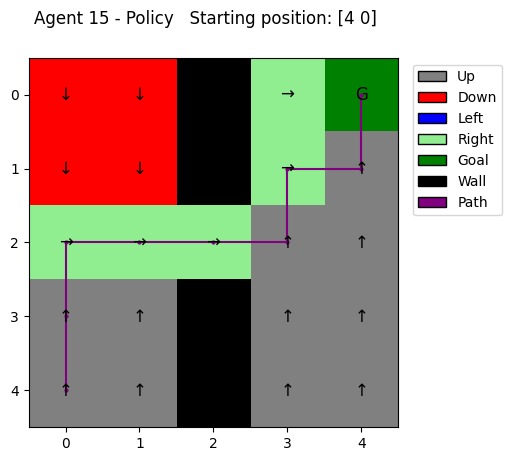

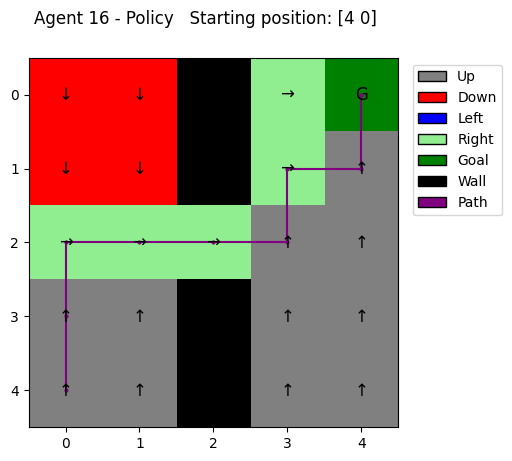

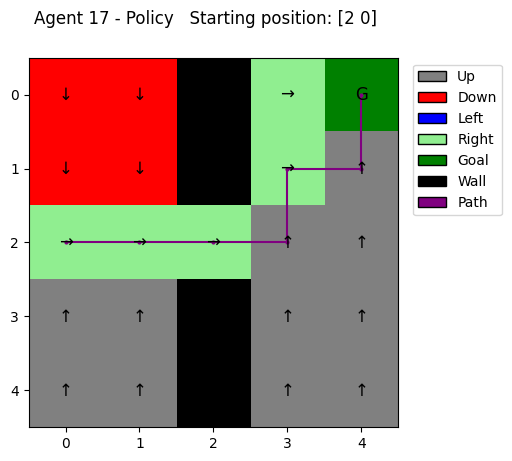

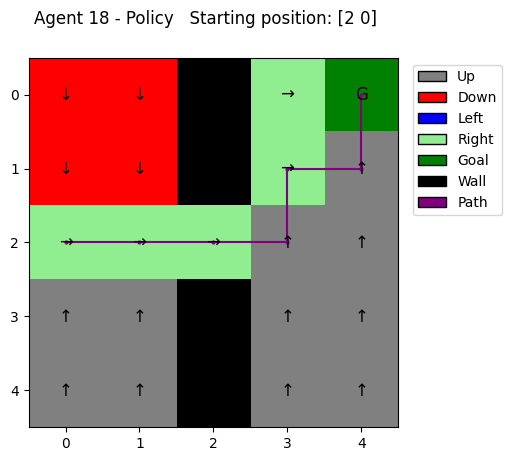

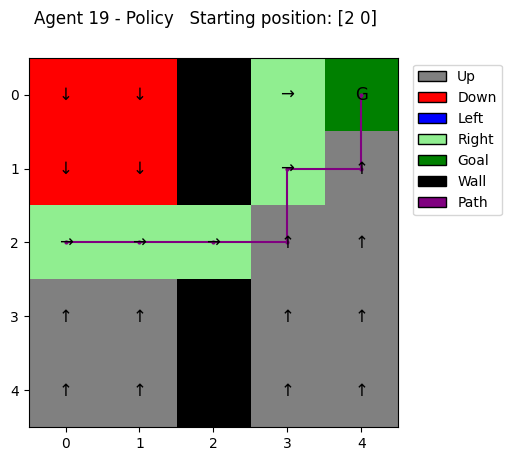

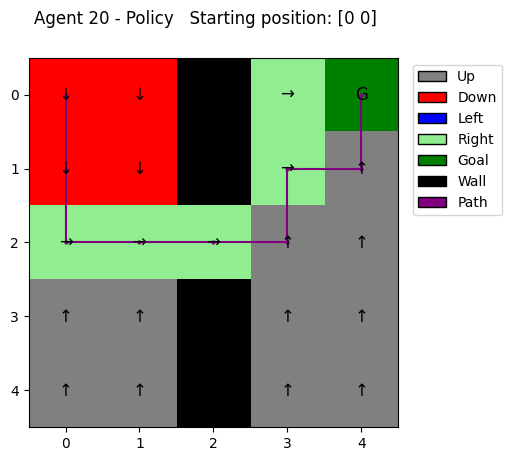

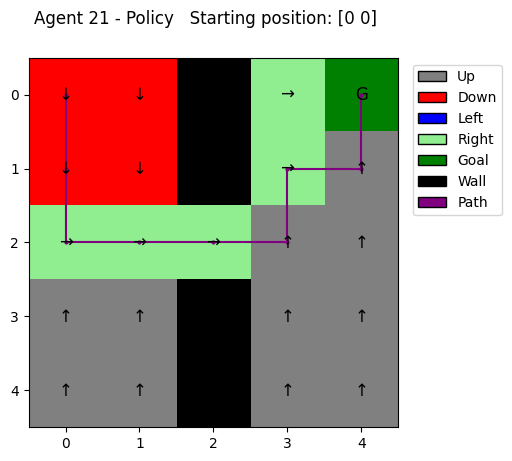

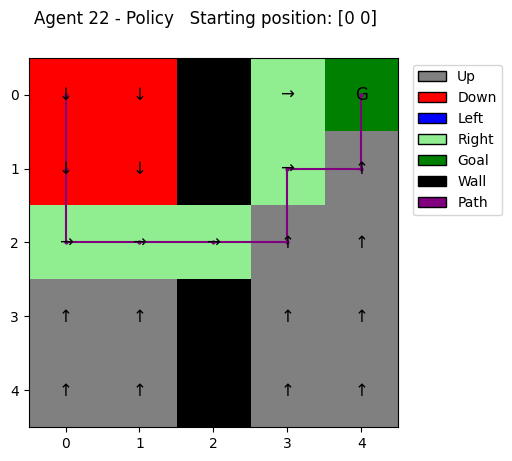

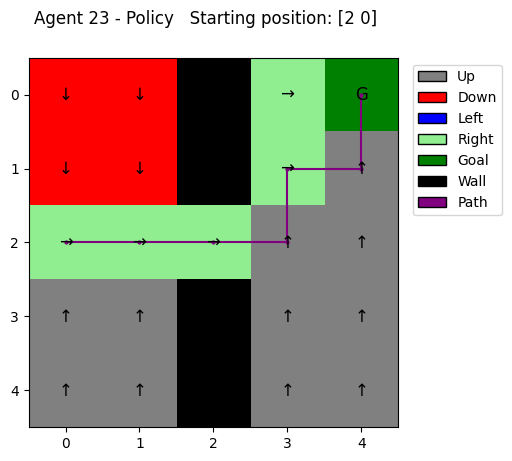

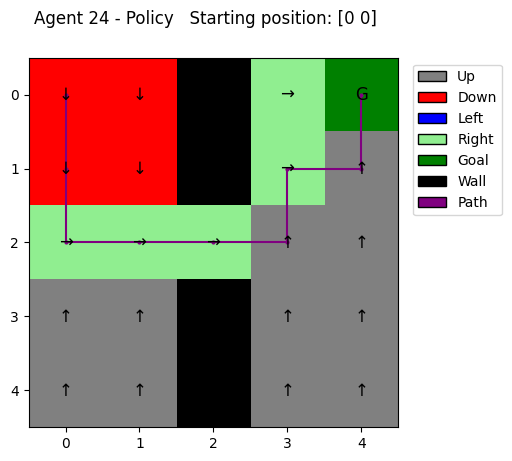

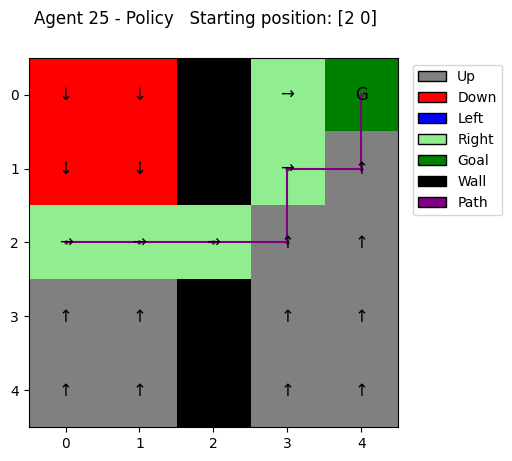

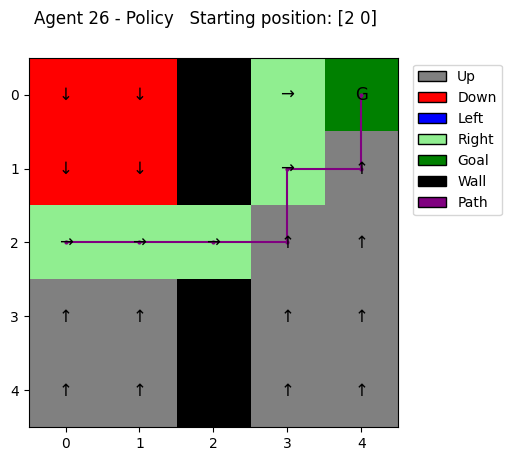

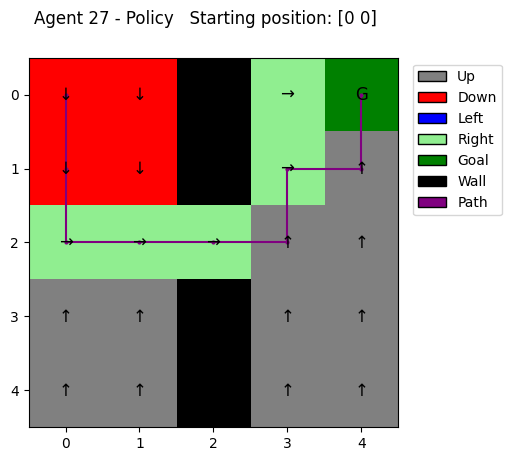

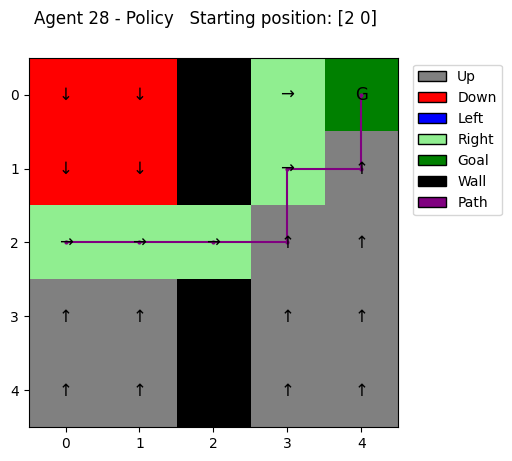

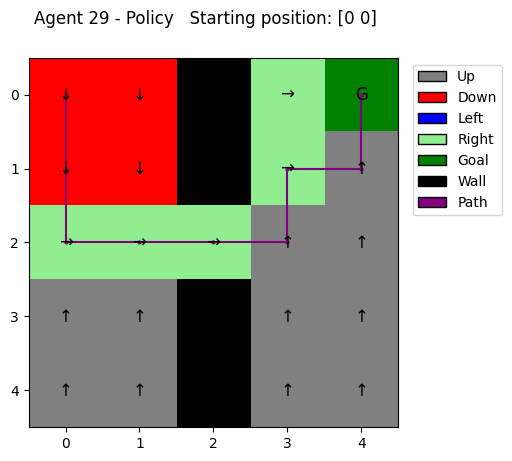

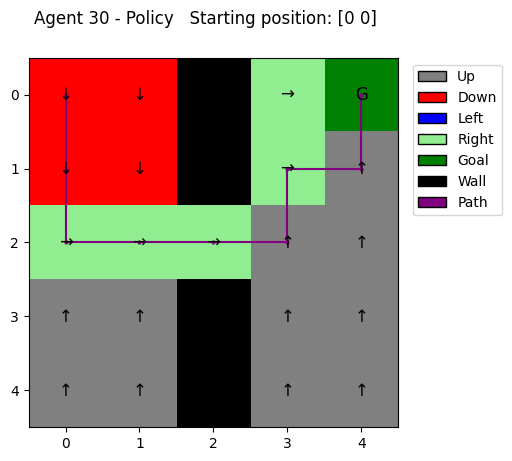

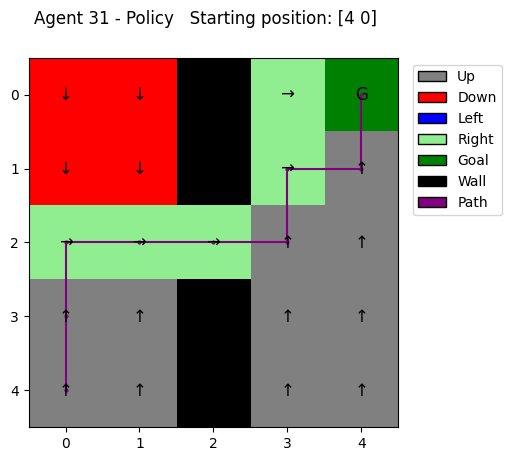

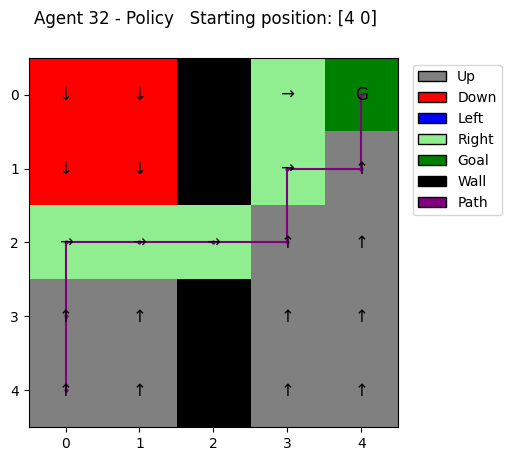

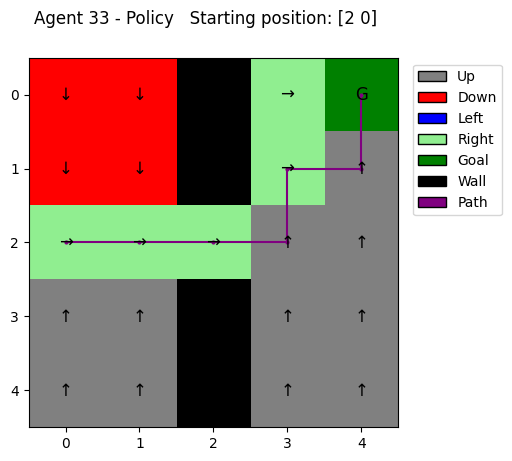

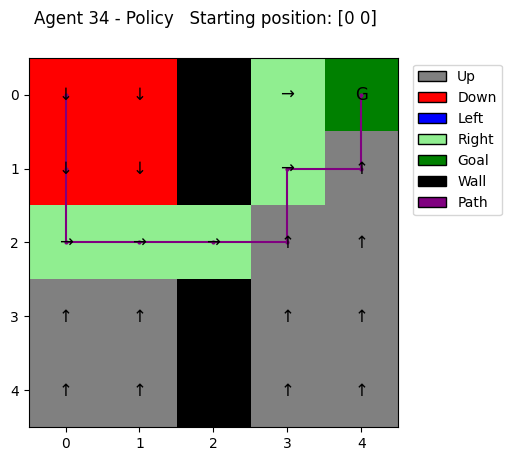

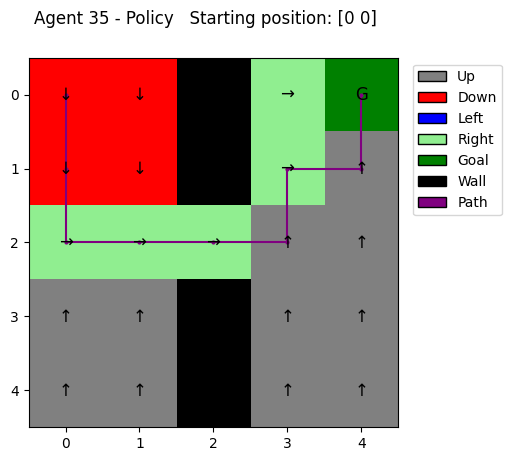

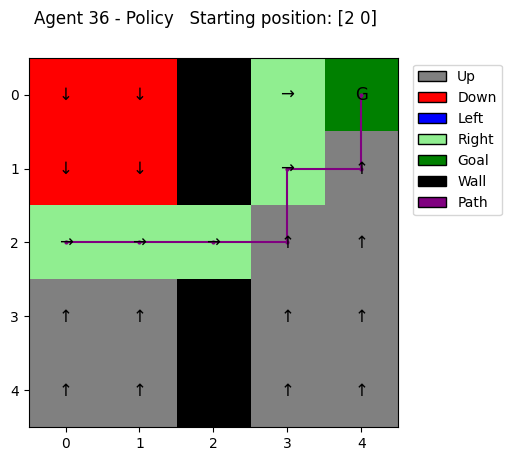

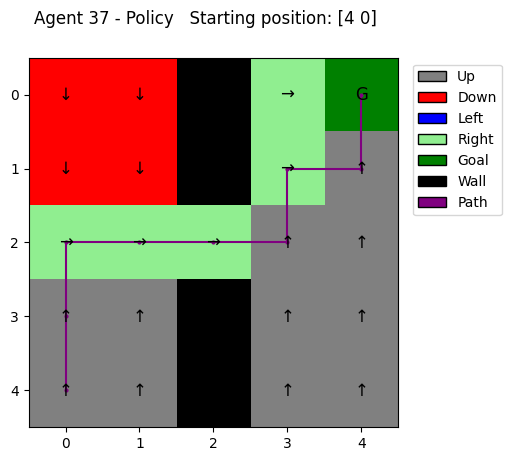

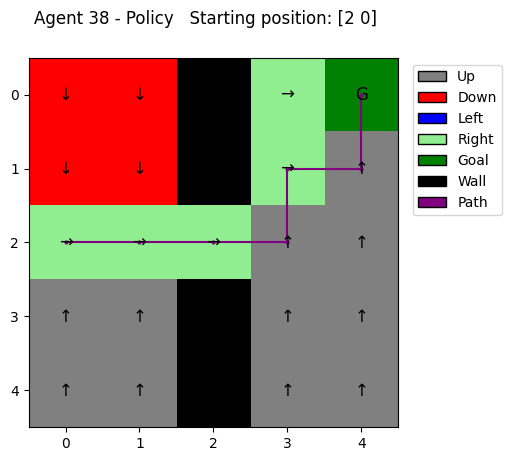

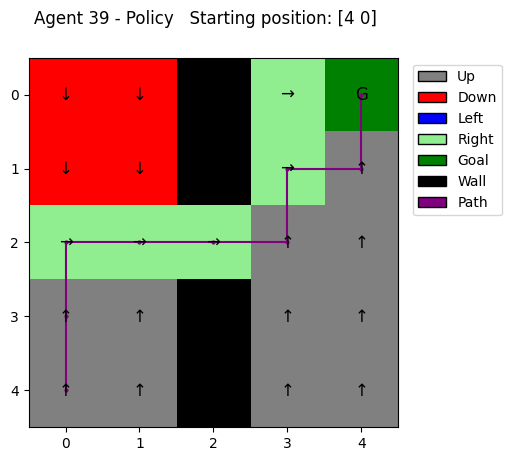

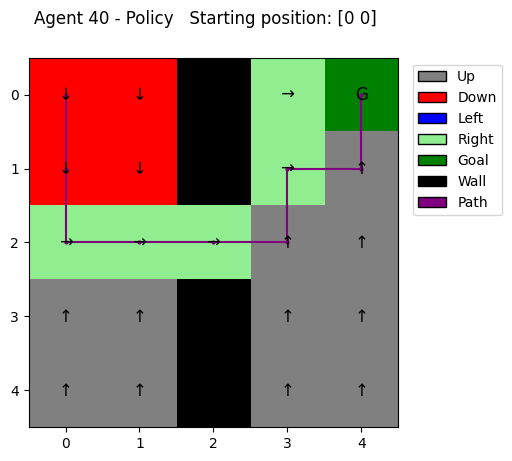

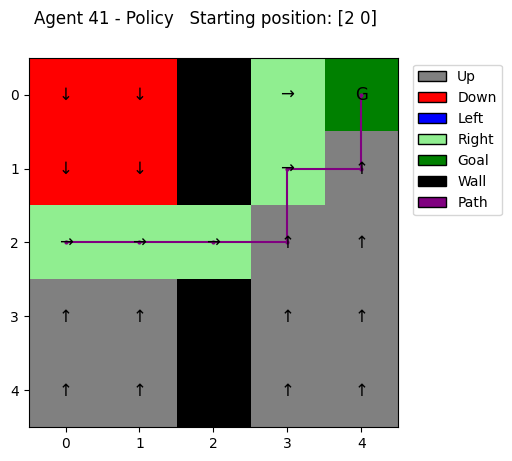

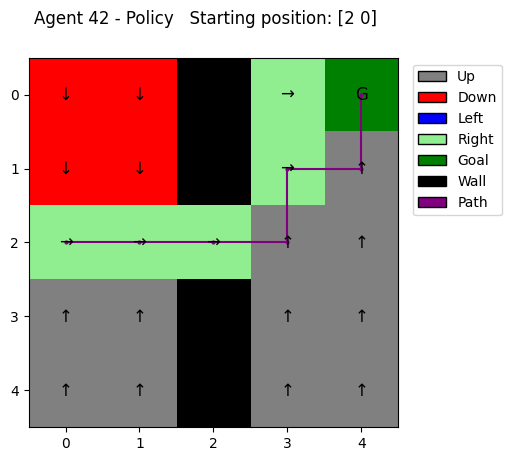

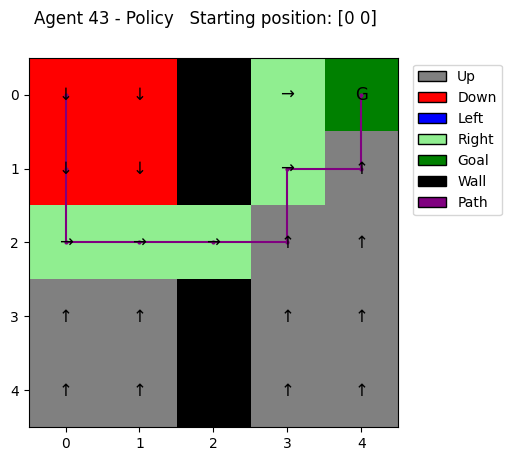

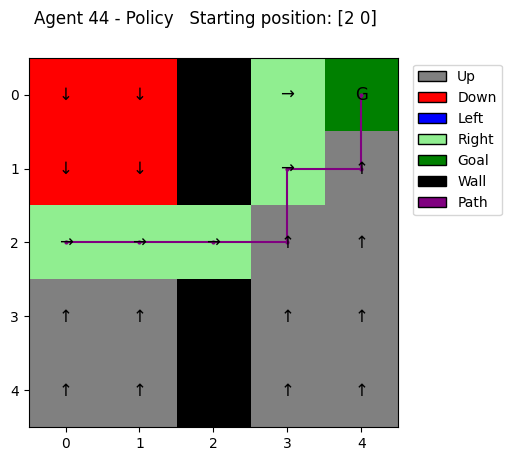

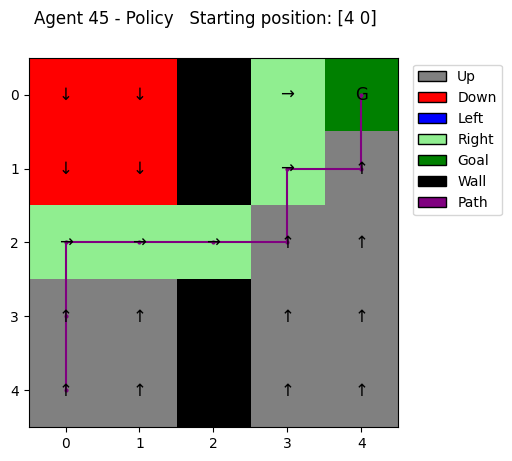

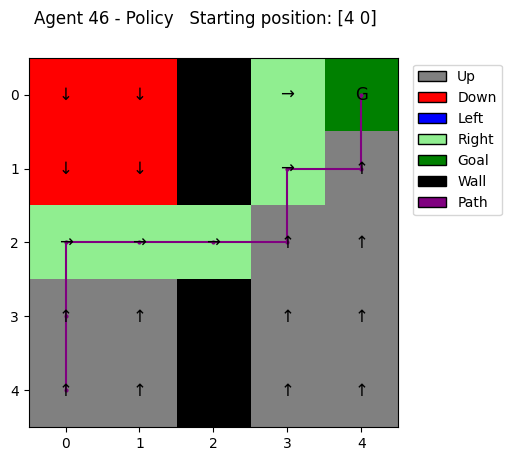

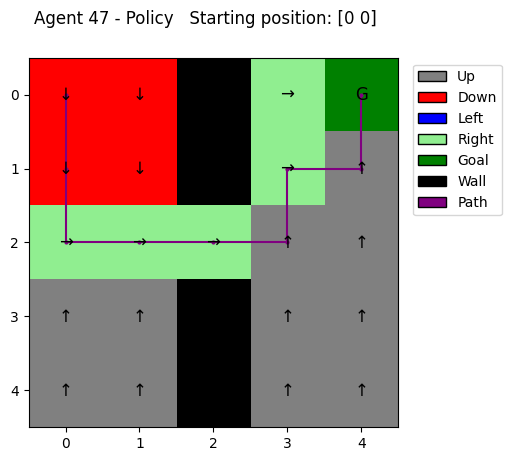

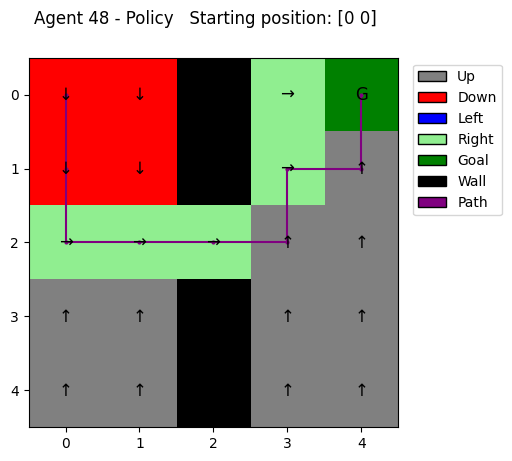

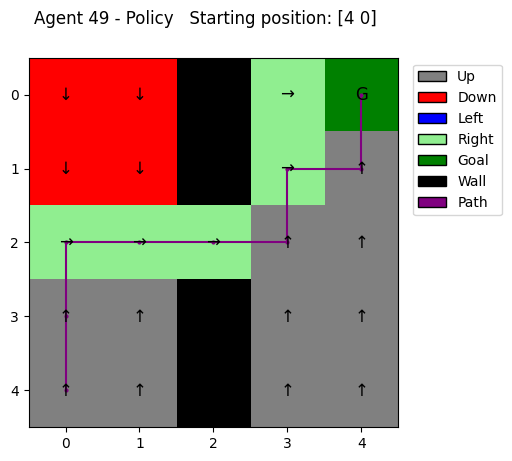

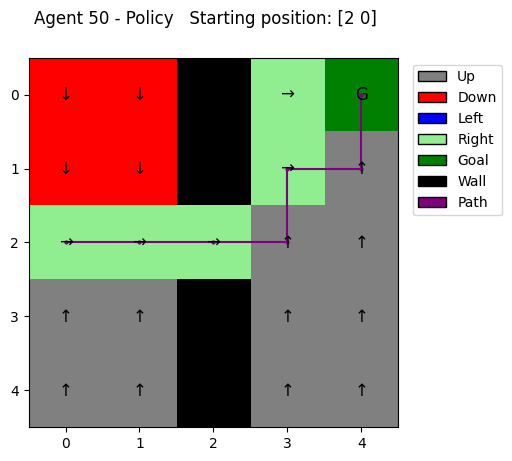

In [ ]:
if train:
    for i in range(len(agents_arr)):
        value_grid, policy_grid, string_policy_grid = create_grids(env, agent=agent)

        if export_to_JSON:
            writeJSON("Q-Learning", n_episodes, 0, shape, starting_positions[i], value_grid, policy_grid, string_policy_grid)
    
        if render:
            fig = plot_trajectory(string_policy_grid, starting_positions[i])
            fig.suptitle(f'Agent {i+1} - Policy   Starting position: {starting_positions[i]}')
            plt.show()